#### <center>[yager.io](https://yager.io)</center>
# <center>RL-Only Neural Network Training</center>

I recently wrote a [blog post](http://yager.io/neural/audiofx/audiofx.html) on training a neural network to emulate audio effects (like guitar pedals). I thought it might be cool to try training a network with RL only, no pre-training.

You can download [this notebook here.](https://github.com/wyager/rl-only/rl.ipynb)

We'll create a neural net that solves mazes.

RL works by:
1. having a model attempt to solve a problem
2. trying to estimate how well the model solved the problem
3. boosting the probability of behaviors that led to good solutions

There are hundreds of variations on this basic concept. You can imagine plenty of different ways to estimate how well the model did, deciding which behaviors led to good solutions, etc.

To make the problem harder on ourselves, we'll use no intermediate reward signal at all. We only learn a reward when the model succeeds, fails, or times out.

We'll estimate the quality of each solution using group-relative scoring, where we let the model try the same problem a bunch of times and compare each outcome to the average score for that problem.

I've never written an RL pipeline from scratch before, so this basically tracks my process of working through/rediscovering all the details, e.g.

* Performance optimization
* Dynamic difficulty-based problem selection
* Choice of objective loss and entropy loss implementations
* Choice of temperature schedule

## Initial Setup

Import all our deps, read some env vars (which we use to run this notebook on a rented GPU server).

In [1]:
# Uncomment to help debug torch compilation issues
# import os
# os.environ["TORCH_LOGS"] = "+dynamo"

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from IPython.display import clear_output
from typing import Self, Iterable
from collections import deque, defaultdict
from dataclasses import dataclass, replace, field
import pandas as pd
import sys
from typing import Generator
from matplotlib.axes import Axes
import json
import base64
import cattrs
import os
import glob as globlib
import warnings

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Enable TF32 for better performance on Ampere+ GPUs (A10, A100, RTX 30xx/40xx)
# Suppress deprecation warning - will update when PyTorch 2.9 is released
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*TF32.*deprecated.*")
    torch.set_float32_matmul_precision("high")

# Trick to avoid torch.multinomial to reduce GPU<>CPU traffic
USE_GUMBEL_NOISE = True  # Testing this
RUN_PERF_ANALYSIS = True

# Environment config for headless/batch execution
HEADLESS = os.environ.get("HEADLESS", "").lower() in ("1", "true", "yes")
EXPERIMENT_CONFIG_FILE = os.environ.get("EXPERIMENT_CONFIG_FILE")

if HEADLESS:
    matplotlib.use("Agg")  # Non-interactive backend for headless execution

For saving trained models, performance statistics, etc. to/from JSON, we use cattrs with some custom hooks for tensors.

In [2]:
def _make_converter(device: torch.device) -> cattrs.Converter:
    """
    Create a cattrs converter with custom hooks for torch types.
    The device parameter determines where tensors are loaded.
    """
    converter = cattrs.Converter()

    # torch.Tensor <-> dict with base64-encoded data
    def tensor_unstructure(t: torch.Tensor) -> dict:
        t = t.detach().cpu().contiguous()
        return {
            "dtype": str(t.dtype),
            "shape": list(t.shape),
            "data_b64": base64.b64encode(t.numpy().tobytes()).decode("ascii"),
            "requires_grad": t.requires_grad,
        }

    def tensor_structure(d: dict, _type) -> torch.Tensor:
        dtype_map = {
            "torch.float32": np.float32,
            "torch.float64": np.float64,
            "torch.int32": np.int32,
            "torch.int64": np.int64,
            "torch.bool": np.bool_,
        }
        raw = base64.b64decode(d["data_b64"])
        arr = np.frombuffer(raw, dtype=dtype_map[d["dtype"]]).reshape(d["shape"])
        t = torch.from_numpy(arr.copy()).to(device)
        if d.get("requires_grad", False):
            t = t.requires_grad_()
        return t

    converter.register_unstructure_hook(torch.Tensor, tensor_unstructure)
    converter.register_structure_hook(torch.Tensor, tensor_structure)

    # torch.device <-> str
    converter.register_unstructure_hook(torch.device, lambda d: str(d))
    converter.register_structure_hook(
        torch.device, lambda s, _: device
    )  # Always use target device

    return converter

Now we'll define our maze type. This is our CPU-side representation; we'll convert it to a different tensor-based representation for GPU calculations.

In [3]:
@dataclass
class Maze:
    """
    CPU-bound representation of a maze problem

    This is only used for problem gen. We do everything on the GPU after initial problem gen
    """

    start: tuple[int, int]
    end: tuple[int, int]
    walls: set[tuple[int, int]]
    w: int
    h: int

    def remove_some_walls(self) -> None:
        to_remove = 1 + int(len(self.walls) * 0.01)
        walls = list(self.walls)
        random.shuffle(walls)
        for wall in walls[:to_remove]:
            self.walls.remove(wall)

    def wall_matrix(self) -> np.ndarray:
        mat = np.zeros((self.h, self.w), dtype="bool")
        for y, x in self.walls:
            mat[y, x] = True
        return mat

    def wins(self) -> bool:
        return self.end == self.start

    # Return the minimum number of moves to solve the maze. None if impossible
    def solve(self) -> int | None:
        q = deque([(self.start, 0)])
        visited = set()
        while q:
            ((y, x), steps) = q.popleft()
            if (y, x) == self.end:
                return steps
            for dy, dx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                y2, x2 = y + dy, x + dx
                if x2 < 0 or x2 == self.w:
                    continue
                if y2 < 0 or y2 == self.h:
                    continue
                if (y2, x2) in self.walls:
                    continue
                if (y2, x2) in visited:
                    continue
                visited.add((y2, x2))
                q.append(((y2, x2), steps + 1))
        return None


def random_maze(h: int, w: int) -> Maze:
    """
    Generate a random maze. Start with a fully blocked off maze
    and keep removing random walls until it's solvable. Not a very fast algorithm
    but it's simple and gives us a uniform distribution over walls.
    """
    start = random.randrange(0, h), random.randrange(0, w)
    end = start
    while end == start:
        end = random.randrange(0, h), random.randrange(0, w)
    walls = set((y, x) for x in range(w) for y in range(h))
    walls.remove(start)
    walls.remove(end)
    maze = Maze(start=start, end=end, walls=walls, w=w, h=h)
    while maze.solve() is None:
        maze.remove_some_walls()
    return maze


example = random_maze(4, 4)
print(example)

Maze(start=(3, 3), end=(0, 2), walls={(0, 1), (0, 0), (3, 1), (2, 2), (3, 2)}, w=4, h=4)


We'll define some dataclasses that we use to keep track of performance during training/eval.

In [4]:
@dataclass
class ProblemSetMetrics:
    """
    Tracks how well we did on a particular problem set
    """

    avg_score: float
    percent_dead: float
    percent_succeeded: float
    # How many attempts did we make at this difficulty level?
    trajectory_count: int
    # How many of those attempts had a non-zero advantage
    # (performed better or worse than average for that problem)?
    # We want some attempts to be better or worse than other attempts at the same problem,
    # or else we learn nothing.
    useful_trajectories: int


@dataclass
class ProblemSetMetricsByDifficulty:
    """
    Split up problem sets by how many steps are required to solve the maze
    """

    by_difficulty: dict[int, ProblemSetMetrics]

## Performance Optimization

I did a number of things to make the compute about ~50x faster than my initial torch code:

### Careful application of @torch.compile

I probably errored out (my fault) or crashed (not my fault) `torch.compile` 20 times. I had to chase down lots of stuff like:

* unsupported dtypes (float64) sneaking in 
* torch trying to fuse huge loops and overloading Metal
* random bugs in torch

### Use Gumbel noise trick instead of `torch.multinomial`

`torch.multinomial` is used to sample one outcome from a probability distribution. You give it a list of probability weights, it picks the index one of them. The problem: `torch.multinomial` resulted in a bunch of GPU<>CPU traffic. In general, you want to watch out for stuff that forces CPU<>GPU sync; it's easy to do by accident and is bad for perf.

There's a mathematical trick with [Gumbel Noise](https://en.wikipedia.org/wiki/Gumbel_distribution) we can use to do the same weighted outcome selection [entirely on the GPU](https://sassafras13.github.io/GumbelSoftmax/), so we use that.

### Batch filtering

Filtering by boolean masks is super slow and required GPU<>CPU traffic. Batch these operations into as large of ops as you can.

### Use `index_select` instead of bitmasks

Instead of applying a bitmask a bunch of times (you guessed it, CPU<>GPU traffic), just create a tensor that contains
indices of all the `True` values. After the initial slow step, this just turns into random reads on the GPU only, which are pretty fast.

### Only collect metrics occasionally

Metrics involve lots of GPU->CPU shuffles (e.g. counting non-zero values) that actually hurt perf a surprising amount. Just do that as infrequently as possible.

## Scoring System

We set our initial score to 2.0, and every turn we multiply the score by some decay term $\alpha$ selected so that if we finish the maze in the optimal number of steps, our final score is 1.0. This gives us a gentle nudge to improve our performance if we take a sub-optimal route, since our final score will be less than 1.0. If we make a wrong move or time out, our score gets set to 0.

## Maze Encoding

To actually feed an $N \times M$ maze to the model, we simply generate a vector with $M*N$ elements. Each element is 0 for an empty cell, 1 for a wall, 2 for the current player position, and 3 for the end goal. The model has to figure out what each of these possible values means.


Now for our GPU-side representation of a large collection of mazes:

In [5]:
@dataclass
class GPUProblemSet:
    """
    A representation of a bunch of mazes that lives on the GPU.
    All the game logic is written using bulk tensor operations.
    """

    # 1 for wall, 0 for no wall
    # (n,h,w)
    walls: torch.Tensor
    # x positions
    xs: torch.Tensor
    # y positions
    ys: torch.Tensor
    # where we need to finish (const)
    end_xs: torch.Tensor
    end_ys: torch.Tensor
    # current score
    score: torch.Tensor
    # How much we decrease the score each turn (const)
    score_multiplier: torch.Tensor
    # We've either solved the maze or died
    done: torch.Tensor
    # How many steps are required, minimum, to solve (const)
    difficulty: torch.Tensor
    device: torch.device

    @torch.compile
    def replicate(self, n: int) -> "GPUProblemSet":
        """
        Makes n adjacent copies of each problem (for generating distinct RL trajectories over the same problem)
        """
        return GPUProblemSet(
            walls=self.walls.repeat_interleave(n, dim=0),
            xs=self.xs.repeat_interleave(n, dim=0),
            ys=self.ys.repeat_interleave(n, dim=0),
            end_xs=self.end_xs.repeat_interleave(n, dim=0),
            end_ys=self.end_ys.repeat_interleave(n, dim=0),
            score=self.score.repeat_interleave(n, dim=0),
            difficulty=self.difficulty.repeat_interleave(n, dim=0),
            score_multiplier=self.score_multiplier.repeat_interleave(n, dim=0),
            done=self.done.repeat_interleave(n, dim=0),
            device=self.device,
        )

    @torch.compile
    def sample(self, n: int) -> "GPUProblemSet":
        """
        Pick a subsample of n problems
        """
        mask = torch.randperm(self.score.size(0), device=self.device)[:n]
        return GPUProblemSet(
            walls=self.walls[mask],
            xs=self.xs[mask],
            ys=self.ys[mask],
            end_xs=self.end_xs[mask],
            end_ys=self.end_ys[mask],
            score=self.score[mask],
            difficulty=self.difficulty[mask],
            score_multiplier=self.score_multiplier[mask],
            done=self.done[mask],
            device=self.device,
        )

    @classmethod
    def from_mazes(
        cls, mazes_by_difficulty: dict[int, list[Maze]], device: torch.device
    ) -> Self:
        """
        Convert CPU mazes to GPU mazes
        """
        mazes: list[tuple[int, Maze]] = [
            (difficulty, maze)
            for (difficulty, mazes) in mazes_by_difficulty.items()
            for maze in mazes
        ]
        walls = torch.tensor(
            np.array([m.wall_matrix() for (_, m) in mazes]),
            dtype=torch.bool,
            device=device,
        )
        (n, _h, _w) = walls.shape
        xs = torch.tensor(
            [m.start[1] for (_, m) in mazes], dtype=torch.int, device=device
        )
        ys = torch.tensor(
            [m.start[0] for (_, m) in mazes], dtype=torch.int, device=device
        )
        end_xs = torch.tensor(
            [m.end[1] for (_, m) in mazes], dtype=torch.int, device=device
        )
        end_ys = torch.tensor(
            [m.end[0] for (_, m) in mazes], dtype=torch.int, device=device
        )
        difficulty = torch.tensor(
            np.array([d for (d, _) in mazes], dtype="int"), device=device
        )
        # Set the initial score to 2, so an optimal run scores 1.0
        score = torch.zeros(n, device=device) + 2.0
        score_multiplier = 0.5 ** (1.0 / difficulty)
        done = torch.tensor(np.array([False for _ in mazes]), device=device)
        return cls(
            walls=walls,
            xs=xs,
            ys=ys,
            end_xs=end_xs,
            end_ys=end_ys,
            score=score,
            difficulty=difficulty,
            score_multiplier=score_multiplier,
            done=done,
            device=device,
        )

    def metrics(self, useful_mask: torch.Tensor) -> ProblemSetMetricsByDifficulty:
        """
        How well we're doing on all the mazes
        """
        by_difficulty: dict[int, ProblemSetMetrics] = {}
        for difficulty in range(1, torch.max(self.difficulty)):
            difficulty_mask = self.difficulty == difficulty
            useful = int((difficulty_mask & useful_mask).sum().cpu().item())
            difficulty_matching = int(difficulty_mask.sum().cpu().item())
            if difficulty_matching == 0:
                continue
            scores = self.score[difficulty_mask]
            done = self.done[difficulty_mask]
            avg_score = scores.mean()
            dead = done & (scores == 0)
            percent_dead = dead.to(torch.float).mean()
            succeeded = done & (scores != 0)
            percent_succeeded = succeeded.to(torch.float).mean()
            # useful_count = (difficulty_mask & (advantages != 0)).sum()
            by_difficulty[difficulty] = ProblemSetMetrics(
                avg_score=avg_score.cpu().item(),
                percent_dead=percent_dead.cpu().item(),
                percent_succeeded=percent_succeeded.cpu().item(),
                useful_trajectories=useful,
                trajectory_count=difficulty_matching,
            )
        return ProblemSetMetricsByDifficulty(by_difficulty=by_difficulty)

    def to(self, device: torch.device) -> "GPUProblemSet":
        """
        Move the problem set to a different device.
        """
        return GPUProblemSet(
            walls=self.walls.to(device),
            xs=self.xs.to(device),
            ys=self.ys.to(device),
            end_xs=self.end_xs.to(device),
            end_ys=self.end_ys.to(device),
            score=self.score.to(device),
            difficulty=self.difficulty.to(device),
            score_multiplier=self.score_multiplier.to(device),
            done=self.done.to(device),
            device=device,
        )

    @torch.compile
    def step_by(self, dx: torch.Tensor, dy: torch.Tensor) -> "GPUProblemSet":
        """
        Move each maze by the given delta and run game logic
        """
        (n, h, w) = self.walls.shape
        assert dx.shape[0] == n
        assert dx.dtype == torch.int
        assert dy.shape[0] == n
        assert dy.dtype == torch.int

        score = self.score * self.score_multiplier

        xs = self.xs + dx
        ys = self.ys + dy
        oob = (xs < 0) | (xs >= w) | (ys < 0) | (ys >= h)
        ys = ys.clamp(0, h - 1)
        xs = xs.clamp(0, w - 1)
        collisions = self.walls[
            torch.arange(n, dtype=torch.int32, device=self.device), ys, xs
        ]

        bad = collisions | oob
        score = torch.where(bad, 0.0, score)

        solved = (xs == self.end_xs) & (ys == self.end_ys)

        done = bad | solved

        return GPUProblemSet(
            walls=self.walls,
            xs=torch.where(self.done, self.xs, xs),
            ys=torch.where(self.done, self.ys, ys),
            end_xs=self.end_xs,
            end_ys=self.end_ys,
            score=torch.where(self.done, self.score, score),
            difficulty=self.difficulty,
            score_multiplier=self.score_multiplier,
            done=torch.where(self.done, self.done, done),
            device=self.device,
        )

    @torch.compile
    def step_dir(self, dirs: torch.Tensor) -> "GPUProblemSet":
        """
        Step each game in the given direction and run game logic.
        """
        assert dirs.shape[0] == self.walls.shape[0]
        assert dirs.dtype == torch.int
        # Direction encoding: 0->U, 1->D, 2->L, 3->R
        dx = (-1) * (dirs == 2).to(torch.int) + 1 * (dirs == 3).to(torch.int)
        dy = (-1) * (dirs == 0).to(torch.int) + 1 * (dirs == 1).to(torch.int)
        return self.step_by(dx, dy)

    @torch.compile
    def to_model_encoding(self) -> torch.Tensor:
        """
        Generates an (N,(HW)) matrix of maze states for feeding to the model
        """
        (n, h, w) = self.walls.shape
        matrix = self.walls.float().clone()
        matrix[
            torch.arange(n, dtype=torch.int32, device=self.device), self.ys, self.xs
        ] += 2
        matrix[
            torch.arange(n, dtype=torch.int32, device=self.device),
            self.end_ys,
            self.end_xs,
        ] += 3
        return matrix.reshape(n, h * w)

    @torch.compile
    def filter(self, mask: torch.Tensor) -> "GPUProblemSet":
        """
        Create a new GPU problem set with undesired problems filtered out.
        """
        return GPUProblemSet(
            walls=self.walls[mask],
            xs=self.xs[mask],
            ys=self.ys[mask],
            end_xs=self.end_xs[mask],
            end_ys=self.end_ys[mask],
            score=self.score[mask],
            difficulty=self.difficulty[mask],
            score_multiplier=self.score_multiplier[mask],
            done=self.done[mask],
            device=self.device,
        )

    @torch.compile
    def index_select(self, indices: torch.Tensor) -> "GPUProblemSet":
        """
        Create a new problem set by pulling problems at the specified indices
        """
        return GPUProblemSet(
            walls=self.walls.index_select(0, indices),
            xs=self.xs.index_select(0, indices),
            ys=self.ys.index_select(0, indices),
            end_xs=self.end_xs.index_select(0, indices),
            end_ys=self.end_ys.index_select(0, indices),
            score=self.score.index_select(0, indices),
            difficulty=self.difficulty.index_select(0, indices),
            score_multiplier=self.score_multiplier.index_select(0, indices),
            done=self.done.index_select(0, indices),
            device=self.device,
        )

    def count(self) -> int:
        """
        How many problems in this problem set?
        """
        (n, _h, _w) = self.walls.shape
        assert self.xs.shape[0] == n
        assert self.ys.shape[0] == n
        assert self.end_xs.shape[0] == n
        assert self.end_ys.shape[0] == n
        assert self.score.shape[0] == n
        assert self.difficulty.shape[0] == n
        assert self.score_multiplier.shape[0] == n
        assert self.done.shape[0] == n
        return n

    @staticmethod
    @torch.compile
    def concat(pss: Iterable["GPUProblemSet"]) -> "GPUProblemSet":
        """
        Combine a bunch of problem sets into one.
        """
        pss = list(pss)
        return GPUProblemSet(
            walls=torch.cat([ps.walls for ps in pss], dim=0),
            xs=torch.cat([ps.xs for ps in pss], dim=0),
            ys=torch.cat([ps.ys for ps in pss], dim=0),
            end_xs=torch.cat([ps.end_xs for ps in pss], dim=0),
            end_ys=torch.cat([ps.end_ys for ps in pss], dim=0),
            score=torch.cat([ps.score for ps in pss], dim=0),
            difficulty=torch.cat([ps.difficulty for ps in pss], dim=0),
            score_multiplier=torch.cat([ps.score_multiplier for ps in pss], dim=0),
            done=torch.cat([ps.done for ps in pss], dim=0),
            device=pss[0].device,
        )


ps = GPUProblemSet.from_mazes({example.solve(): [example]}, device="cpu")
print(ps)
ps = ps.step_dir(torch.tensor([1], dtype=torch.int))
print(ps)

GPUProblemSet(walls=tensor([[[ True,  True, False, False],
         [False, False, False, False],
         [False, False,  True, False],
         [False,  True,  True, False]]]), xs=tensor([3], dtype=torch.int32), ys=tensor([3], dtype=torch.int32), end_xs=tensor([2], dtype=torch.int32), end_ys=tensor([0], dtype=torch.int32), score=tensor([2.]), score_multiplier=tensor([0.8409]), done=tensor([False]), difficulty=tensor([4]), device='cpu')
GPUProblemSet(walls=tensor([[[ True,  True, False, False],
         [False, False, False, False],
         [False, False,  True, False],
         [False,  True,  True, False]]]), xs=tensor([3], dtype=torch.int32), ys=tensor([3], dtype=torch.int32), end_xs=tensor([2], dtype=torch.int32), end_ys=tensor([0], dtype=torch.int32), score=tensor([0.]), score_multiplier=tensor([0.8409]), done=tensor([True]), difficulty=tensor([4]), device='cpu')


This class represents a set of `state -> action -> new state` transition. We generate a bunch of these as we let the model solve mazes.

In [6]:
@dataclass
class StateAction:
    before: GPUProblemSet
    actions: torch.Tensor  # Which actions were taken? (n,) integer 0..4
    after: GPUProblemSet

# Network Architecture

Our neural network is a simple multilayer perceptron with GELU activations.

## Input layer

This layer maps from our maze representation vector (with one element per cell in the maze, set to 0/1/2/3 depending on cell type)
to our internal layer size (e.g. 512)

## Middle layers

We have some configurable number of middle layers, configured as residual blocks. Each layer takes in the output vector from the last layer,
multiplies it by a matrix, applies a bias, applias a GELU, and then adds that to the input vector.

## Output layer

This maps from the final internal vector to a vector of only 4 values; the weights of the 4 possible actions (which are later turned into probabilities using softmax).

In [7]:
@dataclass
class Model:
    """
    Simple MLP with GELU. Maps from maze cell states to logits over {up,down,left,right} moves.

    Would be more idiomatic to use `nn.Module` or something but I wanted to do it by hand.
    """
    input_layer: torch.Tensor  # shape: (input_size, inner_layer_size)
    input_biases: torch.Tensor  # shape: (inner_layer_size,)
    # weights and biases for inner layers
    # each shape: (inner_layer_size, inner_layer_size), (inner_layer_size, )
    inner_layers: list[tuple[torch.Tensor, torch.Tensor]]  
    output_layer: torch.Tensor  # shape: (inner_layer_size, 4)
    output_bias: torch.Tensor  # shape: (4,)
    device: torch.device

    @classmethod
    def new(
        cls,
        device: torch.device,
        w: int,
        h: int,
        inner_layer_size: int,
        num_inner_layers: int,
    ) -> "Model":
        # Avoiding deep GELU blowup
        weight_norm = 1.0 / np.sqrt(inner_layer_size)

        # Model parameters
        # Input layer maps from the input context to our inner layers
        input_layer: torch.Tensor = (
            torch.randn((w * h, inner_layer_size), device=device) * weight_norm
        ).requires_grad_()
        input_biases: torch.Tensor = (
            torch.randn(inner_layer_size, device=device) * weight_norm
        ).requires_grad_()
        # Inner layers do whatever
        inner_layers: list[tuple[torch.Tensor, torch.Tensor]] = [
            ((
                torch.randn((inner_layer_size, inner_layer_size), device=device)
                * weight_norm
            ).requires_grad_(),
            (
                torch.randn(inner_layer_size, device=device) * weight_norm
            ).requires_grad_())
            for _ in range(num_inner_layers)
        ]
        # Maps from our last layer to the up/down/left/right logits.
        output_layer: torch.Tensor = (
            torch.randn((inner_layer_size, 4), device=device) * weight_norm
        ).requires_grad_()
        output_bias: torch.Tensor = (
            torch.randn(4, device=device) * weight_norm
        ).requires_grad_()
        return cls(
            input_layer=input_layer,
            input_biases=input_biases,
            inner_layers=inner_layers,
            output_layer=output_layer,
            output_bias=output_bias,
            device=device,
        )

    def params(self) -> list[torch.Tensor]:
        return (
            [self.input_layer, self.input_biases]
            + [t for (w,b) in self.inner_layers for t in [w,b]]
            + [self.output_layer, self.output_bias]
        )

    def clone(self) -> "Model":
        return Model(
            input_layer=self.input_layer.detach().clone(),
            input_biases=self.input_biases.detach().clone(),
            output_layer=self.output_layer.detach().clone(),
            output_bias=self.output_bias.detach().clone(),
            inner_layers=[(w.detach().clone(), b.detach().clone()) for (w,b) in self.inner_layers],
            device=self.device,
        )

    @torch.compile
    def eval(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Run the model forward
        Handles both single inputs (input_size,) and batched inputs (batch_size, input_size)
        Returns the logits for each action
        """
        vec = torch.nn.functional.gelu(inputs @ self.input_layer + self.input_biases)
        for layer, bias in self.inner_layers:
            vec = vec + torch.nn.functional.gelu(vec @ layer + bias)
        logits = vec @ self.output_layer + self.output_bias  # (batch_size,4)
        # probs = torch.nn.functional.softmax(logits/temperature,dim=1)
        return logits

    # Move the model to a different device
    def to(self, device: torch.device | str) -> "Model":
        return Model(
            input_layer=self.input_layer.to(device),
            input_biases=self.input_biases.to(device),
            inner_layers=[(w.to(device), b.to(device)) for (w,b) in self.inner_layers],
            output_layer=self.output_layer.to(device),
            output_bias=self.output_bias.to(device),
            device=device if isinstance(device, torch.device) else torch.device(device),
        )

    def __repr__(self) -> str:
        lines = [f"Model(device={self.device})"]
        lines.append(f"  input_layer: {self.input_layer.shape}")
        lines.append(f"{self.input_layer}")
        lines.append(f"  input_biases: {self.input_biases.shape}")
        lines.append(f"{self.input_biases}")
        for i, (layer, bias) in enumerate(self.inner_layers):
            lines.append(f"  inner_layer[{i}]: {layer.shape}")
            lines.append(f"{layer}")
            lines.append(f"  inner_bias[{i}]: {bias.shape}")
            lines.append(f"{bias}")
        lines.append(f"  output_layer: {self.output_layer.shape}")
        lines.append(f"{self.output_layer}")
        lines.append(f"  output_bias: {self.output_bias.shape}")
        lines.append(f"{self.output_bias}")
        return "\n".join(lines)

    @torch.compile
    def get_logits(self, ps: GPUProblemSet) -> torch.Tensor:  # (n, 4)
        """
        Get the model's output logits for all the problems in a problem set.
        """
        encoded = ps.to_model_encoding()
        return self.eval(encoded)

    @torch.compile
    def run(self, ps: GPUProblemSet, temperature: torch.Tensor) -> StateAction:
        """
        Step the problem set forward, sampling actions from the model based on its output logits.
        """
        logits = self.get_logits(ps=ps)

        # We can avoid calling `multinomial`, which causes a bunch of CPU traffic,
        # using the Gumbel noise trick. These two blocks should be pretty much equivalent
        if USE_GUMBEL_NOISE:
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-8) + 1e-8)
            noisy_logits = logits / temperature + gumbel_noise
            selections = torch.argmax(noisy_logits, dim=1).to(torch.int)
        else:
            probs = torch.nn.functional.softmax(logits / temperature, dim=1)
            sampled = torch.multinomial(probs, 1).to(torch.int)
            (n, i) = sampled.shape
            assert n == ps.walls.shape[0]
            assert i == 1
            selections = sampled.reshape(n)
        ps2 = ps.step_dir(selections)
        return StateAction(before=ps, actions=selections, after=ps2)

Classes for partitioning problems by their difficulty. Mazes that require 1, 2, 3, ... steps to solve all go in different buckets.

In [8]:
@dataclass
class ProblemsByDifficulty:
    """
    GPU-side problems sharded by difficulty.
    """

    problems: dict[int, GPUProblemSet]


@dataclass
class DifficultySpec:
    """
    Describes how many problems we should generate at each difficulty level.
    args:
        ranges: maps from difficulty to (min count, max count)
    """

    ranges: dict[int, tuple[int, int]]

    def gen_problem_set(
        self, w: int, h: int, device: torch.device
    ) -> ProblemsByDifficulty:
        """
        Generate a bunch of GPUProblemSets at various difficulties
        """
        by_difficulty: defaultdict[int, list[Maze]] = defaultdict(list)

        percent_done: int = 0

        print("Generating problems: ", end="")

        def done(old_percent: int) -> int:
            required = len(self.ranges)
            done = len(
                [
                    None
                    for (difficulty, (lo, _hi)) in self.ranges.items()
                    if len(by_difficulty[difficulty]) >= lo
                ]
            )
            new_percent = (done * 100) // required
            if new_percent != old_percent:
                print(f"{new_percent}% ", end="")
            return new_percent

        while (percent_done := done(percent_done)) != 100:
            maze = random_maze(w=w, h=h)
            difficulty = maze.solve()
            if difficulty is None:
                raise Exception("Got impossible maze in problem gen")
            if (range := self.ranges.get(difficulty)) is not None:
                (_lo, hi) = range
                problems = by_difficulty.setdefault(difficulty, [])
                if len(problems) < hi:
                    problems.append(maze)

        print()

        problems = {
            difficulty: GPUProblemSet.from_mazes(
                mazes_by_difficulty={difficulty: probs}, device=device
            )
            for (difficulty, probs) in by_difficulty.items()
        }
        return ProblemsByDifficulty(problems=problems)


ps_by_difficulty = DifficultySpec({i: (2, 4) for i in range(1, 8)}).gen_problem_set(
    w=6, h=6, device="cpu"
)
ps = GPUProblemSet.concat(ps_by_difficulty.problems.values())

Generating problems: 14% 28% 42% 57% 71% 85% 100% 


Now we'll write a function which runs a model on a `GPUProblemSet` a bunch of times so the models either win, lose, or time out.

In [9]:
# Attempting to @torch.compile this results in an excessively large
# loop fusion.
# I tried manually forcing a smaller fusion size, but it doesn't
# seem to have much perf benefit anyway.
def run_to_completion(
    model: Model, ps: GPUProblemSet, max_iters: int, temperature: torch.Tensor
) -> list[StateAction]:
    """
    Given a model and some problems, run the model to solve all the problems
    (or at least keep going until we crash into a wall).
    """
    sas: list[StateAction] = []
    for _ in range(max_iters):
        sa = model.run(ps=ps, temperature=temperature)
        ps = sa.after
        sas.append(sa)

    # Clamp scores for non-finishing trajectories to zero
    sas[-1].after.score = torch.where(sas[-1].after.done, sas[-1].after.score, 0.0)
    return sas

Some core RL functionality. 

First, a function `do_rl` which runs the model on a bunch of problems. For each problem, we let the model try to solve it N times, and we compare the final scores to find which trajectories seem the best.

Second, a function `flatten_actions` which takes all our RL trajectories and flattens them into a bunch of individual one-step maze problems, so that we can do a single large optimization pass.

An interesting optimization issue in `flatten_actions`: I initially filtered out trajectories where every trajectory had the same score (`advantage == 0`), because we can't learn anything from those trajectories anyway, so including them in our optimization is a waste of compute. This was a nice perf benefit initially. However, the model could get into a bad state where it was super-confident, producing entirely-correct or entirely-incorrect answers for that problem, and those actions would be filtered out, and neither the correctness penalty nor entropy penalty would apply. Then you could end up in a bad state where e.g. if the model got a tough problem, it would just always choose to die, and our entropy loss term couldn't do anything to make it stop doing that.

The easiest fix was just to disable advantage filtering, so that entropy loss is always calculated.

In retrospect, it'd probably be better to do some sort of structural thing like renormalizing the output logits than doing the entropy loss term, but that comes with other challenges.

In [10]:
def do_rl(
    model: Model,
    max_iters: int,
    problem_set: GPUProblemSet,
    repeats: int,
    temperature: torch.Tensor,
) -> tuple[torch.Tensor, list[StateAction]]:
    """
    Run the model forward on a bunch of example maze problems

    returns:
        the (state,action,state) triples from every step
        the final group-relative advantages for each trajectory
            (i.e. the score of each attempt minus the average score for that particular maze)
    """
    trajectories = run_to_completion(
        model=model, ps=problem_set, max_iters=max_iters, temperature=temperature
    )
    final: StateAction = trajectories[-1]
    final_ps: GPUProblemSet = final.after
    # Group all the scores that started from the same state together.
    # This is the core GRPO calculation.
    # Compare each trajectory to other attempts at the same starting problem.
    mazes = problem_set.count()
    score_groups = final_ps.score.reshape(mazes // repeats, repeats)
    group_avg: torch.Tensor = score_groups.mean(axis=1)
    group_avg: torch.Tensor = group_avg.repeat_interleave(repeats)
    # Our group-relative advantage calculation. Any attempt that did better
    # than the average attempt on this problem has a positive advantage.
    advantage: torch.Tensor = final_ps.score - group_avg
    return (advantage, trajectories)


def flatten_actions(
    sequences: list[StateAction], advantages: torch.Tensor
) -> tuple[GPUProblemSet, torch.Tensor, torch.Tensor]:
    """
    Given all transitions and the final advantages,
    create a giant (problem, action, advantage) tensor
    including all non-zero-advantage and non-dead/finished intermediate states.
    Basically everything we want to RL on
    """
    # I initially filtered out rows that had no group-relative advantage,
    # but this is not strictly necessary and it caused a problem where
    # the model would produce outcome distributions with bad entropy
    # and it wouldn't get penalized because
    # all the scores from those groups were equal.
    # interesting: torch.Tensor = advantages != 0.0
    problems: list[GPUProblemSet] = []
    actions: list[torch.Tensor] = []
    advantagess: list[torch.Tensor] = []
    masks: list[torch.Tensor] = []

    for sequence in sequences:
        before: GPUProblemSet = sequence.before
        not_done = ~before.done
        mask = not_done  # & interesting
        masks.append(mask)
        problems.append(before)
        actions.append(sequence.actions)
        advantagess.append(advantages)
    flat_problems = GPUProblemSet.concat(problems)
    flat_actions = torch.cat(actions, dim=0)
    flat_advantages = torch.cat(advantagess, dim=0)
    flat_masks = torch.cat(masks, dim=0)

    # Compute all the indices of non-masked-out state/action tuples
    # This action is expensive, so we want to do it once and then reuse the result a bunch of times
    good_problem_indices = flat_masks.nonzero(as_tuple=True)[0]
    return (
        flat_problems.index_select(good_problem_indices),
        flat_actions.index_select(0, good_problem_indices),
        flat_advantages.index_select(0, good_problem_indices),
    )

Some helper classes for keeping track of interesting metrics as we train the model.

In [11]:
@dataclass
class MetricHistory:
    # Partitioned by problem difficulty
    metrics: dict[int, list[ProblemSetMetrics]] = field(default_factory=lambda: {})
    entropy_losses: list[float] = field(default_factory=lambda: [])
    correctness_losses: list[float] = field(default_factory=lambda: [])

    def update(
        self,
        trajectories: list[StateAction],
        advantages: torch.Tensor,
        correctness_loss: torch.Tensor,
        entropy_loss: torch.Tensor,
    ):
        final_state = trajectories[-1].after
        final_metrics = final_state.metrics(useful_mask=advantages != 0)
        for difficulty, metrics in final_metrics.by_difficulty.items():
            self.metrics.setdefault(difficulty, []).append(metrics)
        self.entropy_losses.append(entropy_loss.mean().cpu().item())
        self.correctness_losses.append(correctness_loss.mean().cpu().item())

    def recent_success_rate(self) -> dict[int, float]:
        """
        What percentage of problems at this difficulty have we succeeded on recently?
        """

        def avg(ms: list[ProblemSetMetrics]) -> float:
            if ms:
                recent = [m.percent_succeeded for m in ms[-20:]]
                return sum(recent) / len(recent)
            else:
                return 0

        return {
            difficulty: avg(history) for (difficulty, history) in self.metrics.items()
        }


@dataclass
class TrainingUpdate:
    training_metrics: MetricHistory
    holdout_metrics: MetricHistory
    model: Model

Our actual loss function.

Takes the actions we randomly sampled from the output logits (and then took), the advantage of each action (positive if the outcome was better than other attempts at the same problem), the temperature (used to increase variance early in training), and the raw output logits. Returns a couple loss terms:

1. A correctness loss term, which we minimize to make the model take the correct move.
2. An entropy loss term, which we minimize to make the model have a "wide" output distribution, so that we can keep our temperature high and get a variety of outcomes. If we don't do something like this, the model quickly becomes ultra-confident in one particular move, and then we don't get enough variety to learn anything.

In [12]:
@dataclass
class LossResult:
    loss: torch.Tensor
    correctness: torch.Tensor
    entropy: torch.Tensor


# Using "reduce-overhead" here causes a crash
@torch.compile
def loss_fn(
    taken_actions: torch.Tensor,
    action_advantages: torch.Tensor,
    temperature: torch.Tensor,
    overall_logits: torch.Tensor,
) -> LossResult:

    # We want to use the temperature to control how much exploration the model does of the problem space.
    # If we can't artificially prop up the model's stochasticity, it becomes too predictable and we don't
    # get enough useful trajectories because they're all the same. We can't learn any lessons if everything
    # succeeds or everything fails; we need some variety in the outcomes. If we don't impose some sort
    # of entropy requirement on the model's output, it learns to boost the strength of its outputs
    # to make the softmax more deterministic, and then RL grinds to a halt.
    # Fixed temperature of 1 so that we're rewarding entropy in logit space, independently
    # of the current training temperature.
    standard_probs = torch.nn.functional.softmax(overall_logits, dim=1)
    entropy = -torch.sum(standard_probs * torch.log(standard_probs + 0.0001), dim=1)
    # I picked a multiplier that is on the same approx scale as the other loss term,
    # but large enough that it keeps a high fraction of "useful trajectories" as the model initially gets
    # its bearings.
    # "Useful trajectories" are those where a group of attempts to solve the same problem
    # have some differences in score.
    entropy_term = -0.1 * entropy

    # If the probability is high, and the advantage is negative, we want to decrease the probability
    # If the probability is low, and the advantage is high, we want to increase the probability
    # Advantage is translated relative to group average
    # So zero advantage should result in zero weight update
    # We want a 2D loss function f(prob,adv) which has, f' being derivative wrt p:
    # f'(p,0) = 0 (no advantage = no gradient)
    # f'(p,a>0) < 0 (decrease loss -> increase p)
    # f'(p,a<0) > 0 (decrease loss -> decrease p)
    # f'(1,a) ~ 0 (we can chill out as we gain confidence about a move)

    # I think we can probably ignore the "no advantage = no gradient" bit.
    # Just might produce some noise in no-advantage environments. Not a big deal.
    # Maybe helpful for escaping local flat regions
    # Negative because we want a > 0 -> df/dp < 0
    a_term = -action_advantages

    # This naturally chills out and reduces gradient size
    # as we approach high confidence about a move being correct.
    # We don't need to worry so much about chilling out near the zero side of things, because we're
    # not going to have many samples around zero.
    # NOTE: Using log_softmax instead of softmax + log for numerical stability.
    # When action probabilities get very small (confident model + low-prob action sampled),
    # softmax can underflow to 0, making log(0) = -inf and causing NaN gradients.
    # log_softmax uses the log-sum-exp trick to avoid this.
    all_log_probs = torch.nn.functional.log_softmax(overall_logits / temperature, dim=1)
    p_term = all_log_probs[
        torch.arange(
            all_log_probs.shape[0], device=overall_logits.device, dtype=torch.int32
        ),
        taken_actions,
    ]

    correctness_term = a_term * p_term

    # Most implementations use `mean()` here.
    # This normally works fine, but I was previously doing advantage filtering
    # (removing actions with no relative advantage), which meant in epochs with
    # very few advantageous trajectories, the few remaining trajectories would have
    # a very large impact, introducing noise. `sum()` was less noisy because it
    # tamped down the loss gradients when we only had a few examples.
    # Now, we're no longer doing advantage filtering, because it
    # undermined the entropy loss, but `sum()` is still fine
    loss = (correctness_term + entropy_term).sum()

    return LossResult(loss=loss, correctness=correctness_term, entropy=entropy_term)

The optimizer:

1. Resets gradients
2. Runs the current model against every sitation that occurred during our practice runs
3. Calculates a loss. Whenever the model made a bad move during practice, that increases our loss.
4. Does backprop and tweaks the model weights to {boost, reduce} the probability of {good, bad} decisions the model made.

In [13]:
@torch.compile
def optimize(
    optimizer: torch.optim.Adam,
    model: Model,
    temperature: torch.Tensor,
    actions: torch.Tensor,
    advantages: torch.Tensor,
    ps: GPUProblemSet,
) -> LossResult:
    optimizer.zero_grad()

    logits = model.get_logits(ps=ps)

    loss = loss_fn(
        taken_actions=actions,
        action_advantages=advantages,
        overall_logits=logits,
        temperature=temperature,
    )

    loss.loss.backward()

    # Clip gradients to prevent instability, particularly
    # when we sample a low-logprob event (high gradient)
    torch.nn.utils.clip_grad_norm_(model.params(), max_norm=1.0)

    optimizer.step()

    return loss

Helper to get an accelerated torch device. I've tested both MPS (on my Macbook) and CUDA (on rented GPU servers).

In [14]:
def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (GPU) device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")
    return device

If a particular difficulty of problem is too hard for us, we don't get enough trajectories where we succeed, so we can't learn anything.

If a difficulty is too easy, we don't get any failures so we also can't learn anything.

Therefore, we want to pick problems which are moderately difficult.

This function cuts down the number of super-easy and super-hard problems so we don't waste compute on them.

In [15]:
def problem_count_for_difficulty(recent_success: float) -> float:
    """
    Given our recent success rate at this difficulty level, what
    fraction of these problems should we keep in the mix?

    If problems are way too hard for us, we should mostly leave them out.
    If problems are way too easy for us, we should mostly leave them out.
    We're largely interested in problems where we succeed sometimes but not always,
    because those give us the most useful information in RL.
    """
    # 0% -> 1%
    # 100% -> 1%
    # 3%..95% -> 100%
    if recent_success < 0.03:
        return 0.01 + 0.99 * (recent_success / 0.03)
    elif recent_success > 0.95:
        return 0.01 + 0.99 * ((1 - recent_success) / 0.05)
    else:
        return 1.0

Generate a GPU problem set by pulling out a bunch of problems of skill-appropriate difficulty.

If a problem is too easy or too hard, every attempt generates the same score (1 or 0) so we get no signal, so we filter those out.

In [16]:
def select_educational_problem_set(
    training_metrics: MetricHistory,
    many_problems_by_difficulty: ProblemsByDifficulty,
    repeats: int,
    epoch_fraction: float,
) -> GPUProblemSet:
    """
    Pull out a subset of all the problems,
    focusing on the problems where we see the most useful success rates,
    then replicate each problem a number of times so we can
    do group-relative advantage calculation
    """
    recent_performance: dict[int, float] = training_metrics.recent_success_rate()
    problem_sets: list[GPUProblemSet] = []
    for difficulty, problems in many_problems_by_difficulty.problems.items():
        if difficulty in recent_performance:
            frac_to_keep = (
                problem_count_for_difficulty(recent_performance[difficulty])
                * epoch_fraction
            )
        else:
            frac_to_keep = epoch_fraction
        count_to_keep = max(int(problems.count() * frac_to_keep), 10)
        problems_to_keep = problems.sample(count_to_keep)
        problem_sets.append(problems_to_keep)

    return GPUProblemSet.concat(problem_sets).replicate(repeats)

Our temperature schedule. We use a geometric decay thing here. I didn't put a ton of effort into this, because it didn't seem to have a large impact on performance, as long as the values were sane.

We start with a high temperature to encourage initial exploration, and we reduce the temperature as the model figures out what it's doing. If our temperature is too high when we're trying to solve long-distance mazes, the model is going to crash into walls before making it to the end of the maze.

In [17]:
def temp(
    epoch: int, max_epoch: int, temp_start: float, temp_end: float, device: torch.device
) -> torch.Tensor:
    t = temp_start * ((temp_end / temp_start) ** (epoch / max_epoch))
    # Otherwise it gets cast to a float64 and breaks compilation on MPS
    return torch.tensor(t, dtype=torch.float32, device=device)

Now some types related to experiment/results management.

In [18]:
@dataclass(frozen=True)
class ExperimentConfig:
    """
    Configuration parameters for our experiment, like how big our mazes should be and how big our NN should be.
    """

    w: int  # Maze width
    h: int  # Maze height
    repeats: int  # How many times should we attempt the same maze per epoch?
    max_iters: int  # How many steps should we give the model to solve the maze?
    inner_layer_size: int  # How wide/tall are the inner matrices?
    num_inner_layers: int  # How many inner layers should the model have?
    epochs: int  # How many epochs should we train for
    epoch_fraction: float  # What fraction of each problem group should we train on per epoch? (Will be less if problem group is too easy/hard)
    update_every: (
        int  # Every `update_every` epochs, pause and check/plot our eval progress
    )
    regen_training_problems_every: (
        int  # How frequently do we generate fresh training data?
    )
    learning_rate: float
    # Where should our training temperature start and end?
    temp_start: float
    temp_end: float

    def format(self) -> str:
        """Format config as a compact string for display."""
        return (
            f"w={self.w} h={self.h} layers={self.num_inner_layers}x{self.inner_layer_size} "
            f"lr={self.learning_rate} repeats={self.repeats} epochs={self.epochs} "
            f"t={self.temp_start}..{self.temp_end}"
        )


@dataclass
class Progress:
    """Serializable snapshot of experiment config and training state."""

    config: ExperimentConfig
    update: TrainingUpdate

    def to_json(self) -> str:
        """Serialize to JSON string."""
        converter = _make_converter(torch.device("cpu"))
        return json.dumps(converter.unstructure(self))

    @staticmethod
    def from_json(json_str: str, device: torch.device) -> "Progress":
        """Deserialize from JSON string, loading tensors to the specified device."""
        converter = _make_converter(device)
        return converter.structure(json.loads(json_str), Progress)


class Experiment:
    """
    An object that holds onto the current state of our running experiment.
    """

    device: torch.device
    config: ExperimentConfig
    model: Model
    training_metrics: MetricHistory
    holdout_metrics: MetricHistory
    epoch: int = 0
    optimizer: torch.optim.Adam
    holdout_problems: GPUProblemSet
    training_problems: ProblemsByDifficulty
    training_spec: DifficultySpec

    def __init__(
        self,
        device: torch.device,
        config: ExperimentConfig,
        eval_problems: ProblemsByDifficulty,
        training_spec: DifficultySpec,
    ):
        self.device = device
        self.config = config
        self.model = Model.new(
            device=device,
            w=config.w,
            h=config.h,
            inner_layer_size=config.inner_layer_size,
            num_inner_layers=config.num_inner_layers,
        )
        self.training_metrics = MetricHistory()
        self.holdout_metrics = MetricHistory()
        # Set up the optimizer
        # Experimentally, lr=0.001 seemed to take a bit longer to "launch",
        # and while it had a faster climbing phase, it seemed to oscillate around
        # 80% correctness rather than smoothly converging to ~100%.
        # 0.0004 seemed to more gracefully take off and slide up to 100% even though
        # its peak slope was maybe ~30% less
        self.optimizer = torch.optim.Adam(self.model.params(), lr=config.learning_rate)
        self.holdout_problems: GPUProblemSet = GPUProblemSet.concat(
            eval_problems.problems.values()
        )
        self.training_spec = training_spec

    def one_epoch(self) -> TrainingUpdate | None:
        temperature = temp(
            epoch=self.epoch,
            max_epoch=self.config.epochs,
            temp_start=self.config.temp_start,
            temp_end=self.config.temp_end,
            device=self.device,
        )

        if self.epoch % self.config.regen_training_problems_every == 0:
            # We want to periodically get fresh training data.
            # Too little training data in memory => regen too frequently, lots of GPU traffic
            # Too much training data in memory => problem subset sample perf gets bad
            self.training_problems = self.training_spec.gen_problem_set(
                w=self.config.w, h=self.config.h, device=self.device
            )

        # Pick some problems which are moderately difficult for the current model.
        # Too easy => all 1.0 scores => no learning
        # Too hard => all 0.0 scores => no learning
        problem_set = select_educational_problem_set(
            training_metrics=self.training_metrics,
            many_problems_by_difficulty=self.training_problems,
            epoch_fraction=self.config.epoch_fraction,
            repeats=self.config.repeats,
        )

        # First, do a bunch of maze runs so we have some example data to learn against
        with torch.no_grad():
            (advantages, trajectories) = do_rl(
                model=self.model,
                max_iters=self.config.max_iters,
                problem_set=problem_set,
                repeats=self.config.repeats,
                temperature=temperature,
            )

            (flat_problems, flat_actions, flat_advantages) = flatten_actions(
                sequences=trajectories, advantages=advantages
            )

        # Now that we have example data, let's go ahead and update our actions
        loss: LossResult = optimize(
            optimizer=self.optimizer,
            model=self.model,
            temperature=temperature,
            actions=flat_actions,
            advantages=flat_advantages,
            ps=flat_problems,
        )

        self.epoch += 1

        if self.epoch % self.config.update_every == 0:
            self.run_eval(trajectories=trajectories, advantages=advantages, loss=loss)
            return self.get_training_update()

    def run_eval(
        self,
        trajectories: list[StateAction],
        advantages: torch.Tensor,
        loss: LossResult,
    ):
        self.training_metrics.update(
            trajectories=trajectories,
            advantages=advantages,
            correctness_loss=loss.correctness,
            entropy_loss=loss.entropy,
        )
        (holdout_advantages, holdout_trajectories) = do_rl(
            model=self.model,
            max_iters=self.config.max_iters,
            problem_set=self.holdout_problems,
            repeats=1,
            temperature=torch.tensor(0.01, device=self.device),
        )
        self.holdout_metrics.update(
            trajectories=holdout_trajectories,
            advantages=holdout_advantages,
            correctness_loss=torch.zeros([1]),
            entropy_loss=torch.zeros([1]),
        )

    def get_training_update(self) -> TrainingUpdate:
        return TrainingUpdate(
            training_metrics=self.training_metrics,
            holdout_metrics=self.holdout_metrics,
            model=self.model.clone(),
        )

    def train(self) -> Generator[TrainingUpdate, None, None]:
        while self.epoch < self.config.epochs:
            if result := self.one_epoch():
                yield result

A function to plot some relevant metrics for a given training run + eval data.

In [19]:
def plot_one(
    training_history: MetricHistory,
    eval_history: MetricHistory,
    axa: Axes,
    axb: Axes,
    axc: Axes,
    axd: Axes,
    axe: Axes,
    update_every: int,
):
    axa.set_ylabel(f"Score")
    axa.set_title(f"Avg score by difficulty (Training)")

    axb.set_ylabel(f"Loss")
    axb.set_title(f"Loss (Training)")

    axc.set_ylabel(f"Fraction useful")
    axc.set_title(f"Frac trajectories providing signal (Training)")
    # Use symlog scale to give more resolution near 0
    # Linear from 0 to linthresh, then logarithmic above
    # This makes small values (0.001, 0.01, 0.1) visually distinguishable
    axc.set_yscale("symlog", linthresh=0.001)
    axc.set_ylim(bottom=0, top=1)

    axd.set_ylabel(f"Useful")
    axd.set_title(f"Total trajectories run by difficulty (Training)")
    axd.set_yscale("symlog", linthresh=1)
    axd.set_ylim(bottom=0.9, top=1e5)

    axe.set_ylabel("Score")
    axe.set_title("Avg score by difficulty (Holdout)")

    xs = list(i * update_every for i in range(len(training_history.correctness_losses)))

    def plot_ax(ax: Axes, label, vals: list[float]):
        s = pd.Series(vals)
        rolling = s.rolling(window=max(1, len(vals) // 200))
        mean = rolling.mean()
        std = rolling.std()
        ax.plot(xs, mean, label=label)
        ax.fill_between(xs, mean - std, mean + std, alpha=0.3)

    for difficulty, metrics in training_history.metrics.items():
        scores = [m.avg_score for m in metrics]
        traj_count = [m.trajectory_count for m in metrics]
        frac_useful = [m.useful_trajectories / m.trajectory_count for m in metrics]

        plots = [(axa, scores), (axc, frac_useful), (axd, traj_count)]

        for ax, vals in plots:
            plot_ax(ax, label=f"{difficulty}", vals=vals)

    for difficulty, metrics in eval_history.metrics.items():
        scores = [m.avg_score for m in metrics]

        plots = [(axe, scores)]

        for ax, vals in plots:
            plot_ax(ax, label=f"{difficulty}", vals=vals)

    for name, losses in [
        ("entropy", training_history.entropy_losses),
        ("correctness", training_history.correctness_losses),
    ]:
        plot_ax(axb, vals=losses, label=name)

    for ax in [axa, axb, axc, axd, axe]:
        ax.set_xlabel("Epoch")
        ax.grid(True)
        ax.legend()


def plot(progress: Progress):
    """Plot training progress with config info displayed."""

    # Print config info
    print(f"Config: {progress.config.format()}")

    _fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 18))

    plot_one(
        progress.update.training_metrics,
        progress.update.holdout_metrics,
        ax1,
        ax2,
        ax3,
        ax4,
        ax5,
        progress.config.update_every,
    )

    # Hide unused axis
    ax6.axis("off")

    plt.tight_layout()
    plt.show()

Now let's define some specs for our experiment, e.g. how many problems to generate and at what difficulty level.

If the EXPERIMENT_CONFIG_FILE is defined, we load the experiment definition from there. If it's not, we just use a little demo experiment.

In [20]:
# When we generate training problems, follow this spec
training_spec = DifficultySpec(
    {
        # A lot of easy problems, a few hard problems.
        # Would be interesting to see if difficulty distribution has any strong effects.
        # We already dynamically adjust difficulty selection size based on model pass rate.
        difficulty: (1000 // difficulty, 1000 // difficulty)
        for difficulty in range(1, 11)
    }
)


# Load config from JSON file if EXPERIMENT_CONFIG_FILE env var is set, otherwise use default
if EXPERIMENT_CONFIG_FILE:
    with open("experiments/" + EXPERIMENT_CONFIG_FILE) as f:
        config_json = json.load(f)
    converter = _make_converter(torch.device("cpu"))
    experiment_config: ExperimentConfig = converter.structure(
        config_json, ExperimentConfig
    )
    print(f"Loaded config from {EXPERIMENT_CONFIG_FILE}: {experiment_config.format()}")
else:
    experiment_config: ExperimentConfig = ExperimentConfig(
        w=5,
        h=5,
        epoch_fraction=0.2,
        repeats=16,
        max_iters=20,
        epochs=400,
        update_every=10,
        num_inner_layers=5,
        inner_layer_size=512,
        regen_training_problems_every=500,
        learning_rate=0.0004,
        temp_start=1.0,
        temp_end=0.1,
    )

device = get_device()


# Generate a fixed set of eval problems which are not trained on
holdout_spec = DifficultySpec({difficulty: (100, 100) for difficulty in range(1, 12)})
eval_problems: ProblemsByDifficulty = holdout_spec.gen_problem_set(
    w=experiment_config.w, h=experiment_config.h, device=device
)

Using MPS (GPU) device
Generating problems: 9% 18% 27% 36% 45% 54% 63% 72% 81% 90% 100% 


If we're running in HEADFUL mode (i.e. a human-interactive Jupyter notebook), generate some experiments that we can run on a GPU server.

I know there are fancy libraries where you just put `@decorator`s on your code and it zaps it off to a GPU server, but I didn't really want to figure out how to make that stuff work for this post, so I just ran this notebook on some rented GPU boxes with `HEADLESS=1 EXPERIMENT_CONFIG_FILE=experiments/whatever.json`.

In [21]:
if not HEADLESS:
    # Generate experiment config files for hyperparameter sweep
    os.makedirs("experiments", exist_ok=True)
    converter = _make_converter(torch.device("cpu"))

    default_size = 512
    default_layers = 4
    default_temp_decay = 10

    experiments = [(default_size, default_layers, default_temp_decay)]

    for size_experiment in [256, 1024]:
        experiments.append((size_experiment, default_layers, default_temp_decay))
    for layer_experiment in [2, 8, 16]:
        experiments.append((default_size, layer_experiment, default_temp_decay))
    for temp_decay_experiment in [2, 50]:
        experiments.append((default_size, default_layers, temp_decay_experiment))

    for inner_layer_size, num_inner_layers, temp_decay in experiments:
        baseline_compute = 100_000
        # Experimental fudge factor to get wall-time training cost
        # roughly the same for each network
        extra_compute = ((512 / inner_layer_size) * (8 / num_inner_layers)) ** 0.5
        epoch_count = int(baseline_compute * extra_compute)
        config = ExperimentConfig(
            w=5,
            h=5,
            epoch_fraction=0.2,
            repeats=16,
            max_iters=20,
            epochs=epoch_count,
            update_every=epoch_count // 1000,
            num_inner_layers=num_inner_layers,
            inner_layer_size=inner_layer_size,
            regen_training_problems_every=epoch_count // 250,
            learning_rate=0.0004,
            temp_start=1.0,
            temp_end=1.0 / temp_decay,
        )
        path = f"experiments/experiment-{inner_layer_size}-{num_inner_layers}-{temp_decay}.json"
        with open(path, "w") as f:
            json.dump(converter.unstructure(config), f, indent=2)
        print(f"Wrote {path}: {config.format()}")

Wrote experiments/experiment-512-4-10.json: w=5 h=5 layers=4x512 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.1
Wrote experiments/experiment-256-4-10.json: w=5 h=5 layers=4x256 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.1
Wrote experiments/experiment-1024-4-10.json: w=5 h=5 layers=4x1024 lr=0.0004 repeats=16 epochs=100000 t=1.0..0.1
Wrote experiments/experiment-512-2-10.json: w=5 h=5 layers=2x512 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.1
Wrote experiments/experiment-512-8-10.json: w=5 h=5 layers=8x512 lr=0.0004 repeats=16 epochs=100000 t=1.0..0.1
Wrote experiments/experiment-512-16-10.json: w=5 h=5 layers=16x512 lr=0.0004 repeats=16 epochs=70710 t=1.0..0.1
Wrote experiments/experiment-512-4-2.json: w=5 h=5 layers=4x512 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.5
Wrote experiments/experiment-512-4-50.json: w=5 h=5 layers=4x512 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.02


This little snippet runs some training code with torch profiling turned on. Helpful for figuring out bottlenecks in your torch code. I was able to get my final code something like 50x faster than my initial code pretty easily with this dev loop.

In [22]:
if RUN_PERF_ANALYSIS:

    def run_steps(n: int):
        config = replace(experiment_config, epochs=n, update_every=10)
        perf_experiment = Experiment(
            device=device,
            config=config,
            eval_problems=eval_problems,
            training_spec=training_spec,
        )
        for _update in perf_experiment.train():
            pass

    # Warm up JIT
    run_steps(10)

    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU]
    ) as prof:
        run_steps(50)
    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

Generating problems: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 


W0207 16:20:54.198000 2383 torch/_logging/_internal.py:1199] [11/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Generating problems: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          aten::nonzero        38.35%        2.995s        40.01%        3.124s      13.018ms           240  
                                               aten::mm        18.52%        1.446s        18.57%        1.450s     166.088us          8730  
                             Torch-Compiled Region: 8/2         9.06%     707.647ms        20.30%        1.585s      31.707ms            50  
                                            aten::copy_         7.78%     607.413ms  

Our actual "production" experiment. If you don't have `EXPERIMENT_CONFIG_FILE` set, it just runs a few hundred epochs.

In [23]:
prod_experiment = Experiment(
    config=experiment_config,
    device=device,
    eval_problems=eval_problems,
    training_spec=training_spec,
)

Run the prod experiment. If we're in HEADFUL mode, we can also plot our progress.

Config: w=5 h=5 layers=5x512 lr=0.0004 repeats=16 epochs=400 t=1.0..0.1


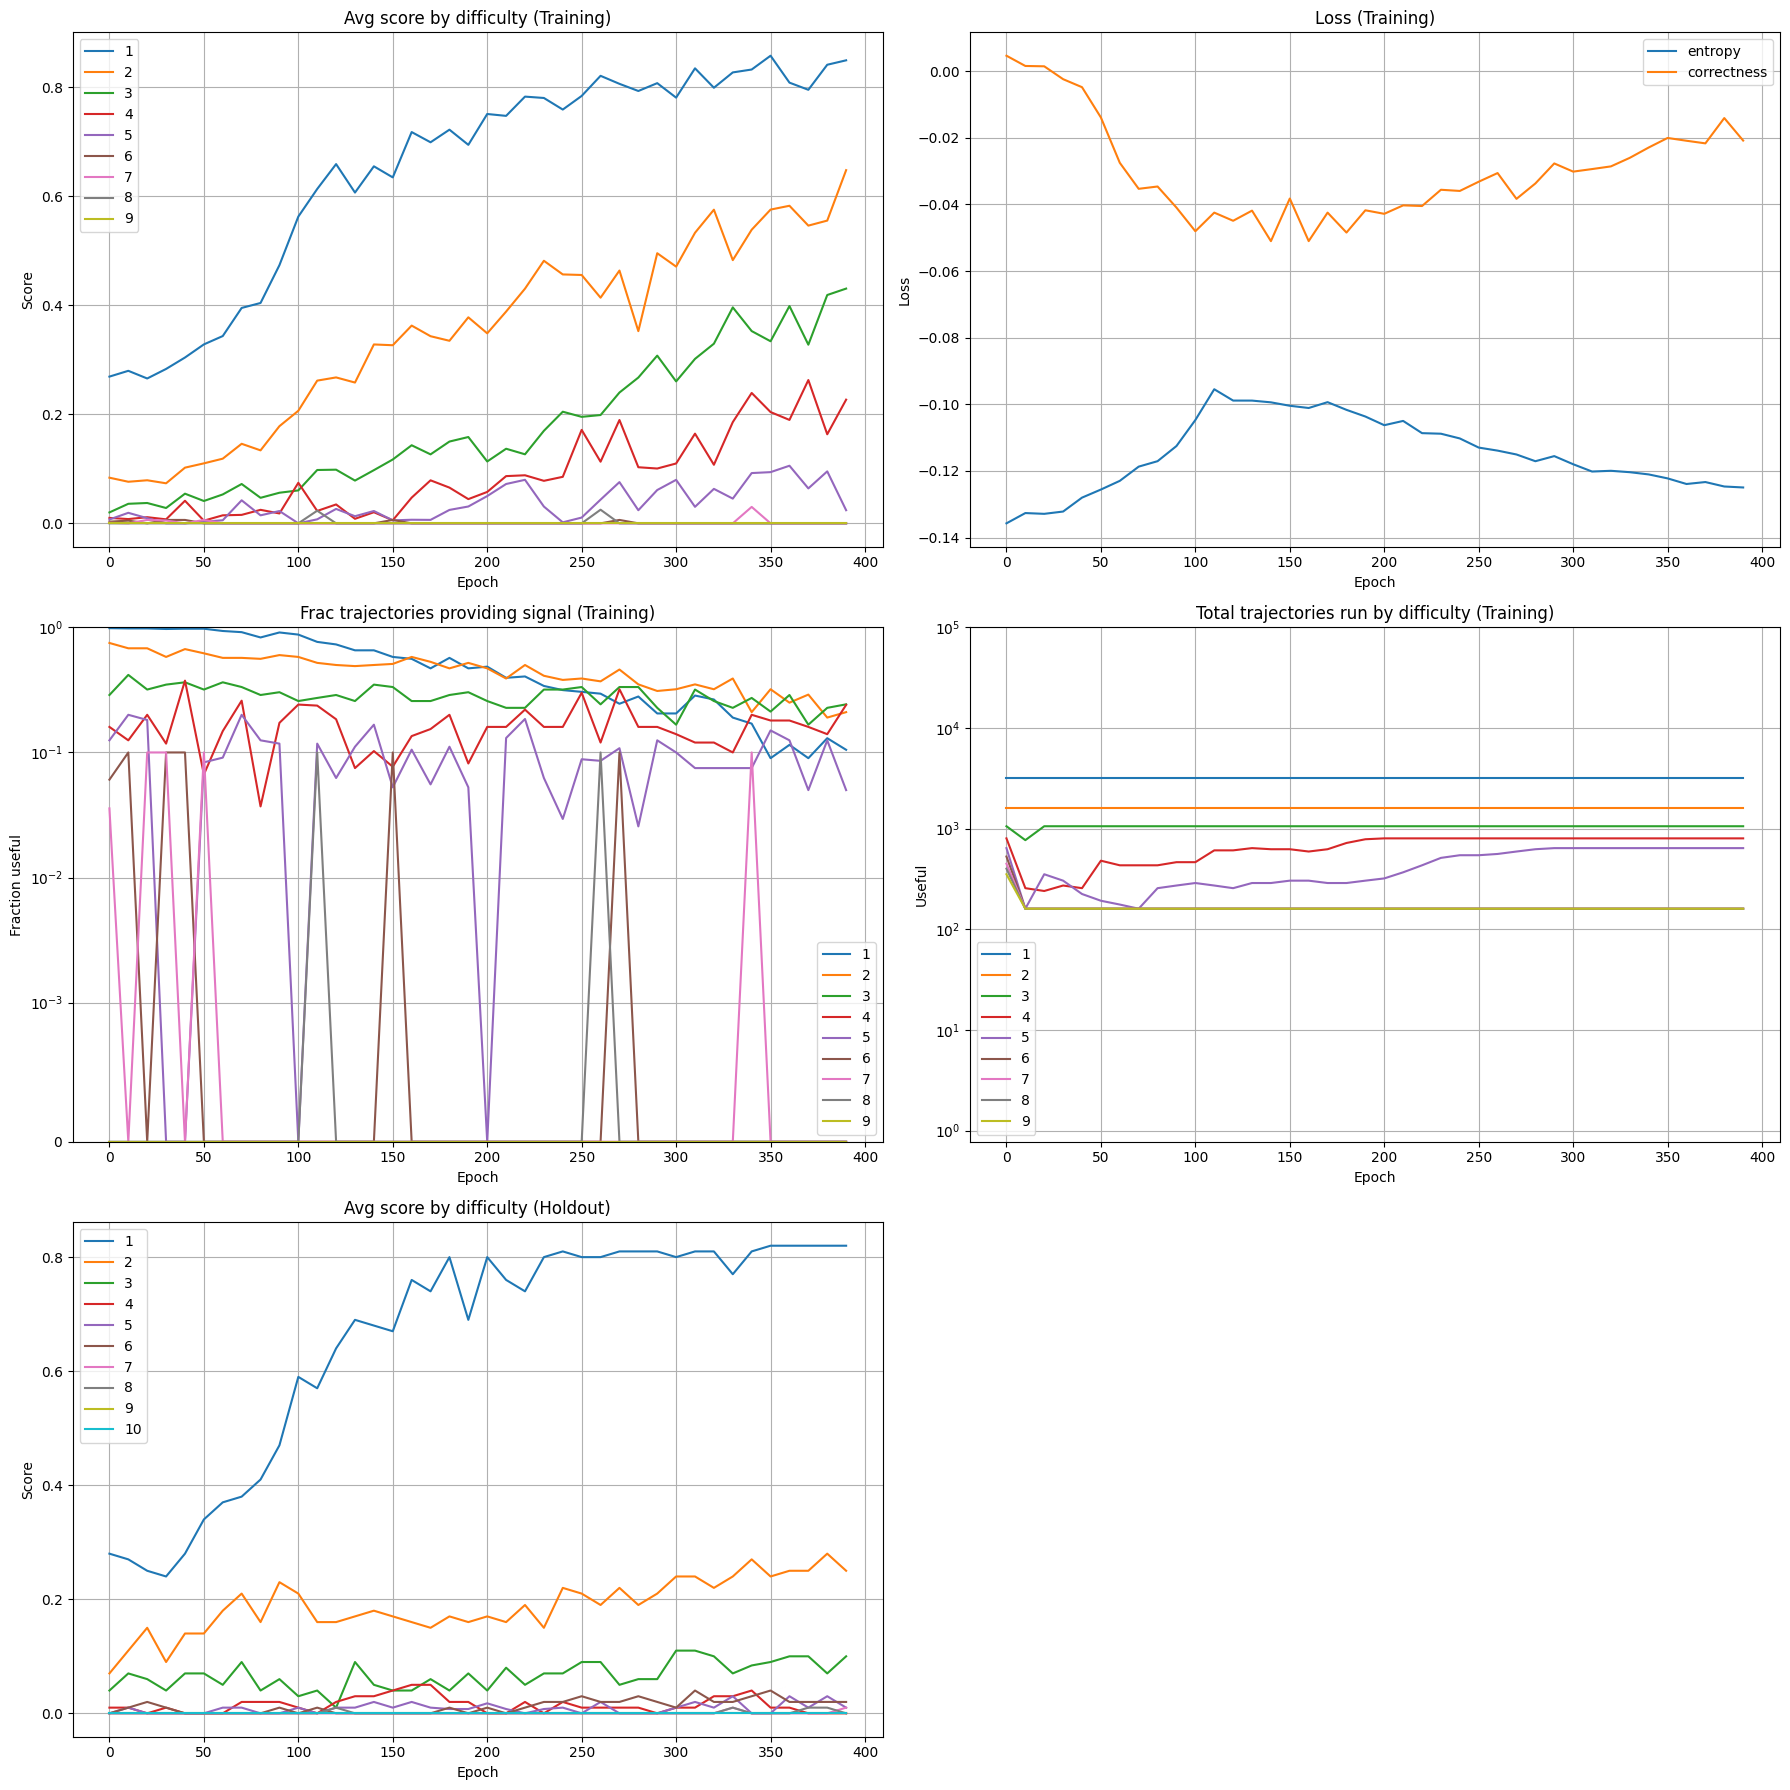

In [24]:
for update in prod_experiment.train():
    if HEADLESS:
        # Print progress to stderr for headless monitoring (not captured by notebook)
        epoch = (
            len(update.training_metrics.correctness_losses)
            * experiment_config.update_every
        )
        avg_scores = {
            d: m[-1].avg_score for d, m in update.training_metrics.metrics.items() if m
        }
        print(f"Epoch {epoch}: {avg_scores}", file=sys.stderr, flush=True)
    else:
        progress = Progress(config=experiment_config, update=update)
        clear_output(wait=True)
        plot(progress)

Save our progress to disk, including training metrics and the final model.

In [25]:
progress = Progress(
    config=experiment_config, update=prod_experiment.get_training_update()
)
if EXPERIMENT_CONFIG_FILE:
    os.makedirs("results", exist_ok=True)
    save_path = "results/" + EXPERIMENT_CONFIG_FILE
else:
    save_path = "/tmp/experiment.json"

with open(save_path, "w") as f:
    f.write(progress.to_json())

If we're running on a GPU server, we can bail out here.

In [26]:
if HEADLESS:
    raise Exception("We are done")

Load all the results from our GPU servers.

Sort the results by how well it looks like they generalized.

We only train with up to difficulty-9 problems, so look at our recent avg perf on difficulty-10 problems.

We plot metrics for the 3 best training runs.

You'll notice that as the temperature drops, the entropy loss goes down and the correctness loss goes up, because the model can afford to have a wider probability distribution without making a wrong move too often.

Loaded w=5 h=5 layers=4x1024 lr=0.0004 repeats=16 epochs=100000 t=1.0..0.1. Perf: 0.9503348422050476
Loaded w=5 h=5 layers=4x512 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.1. Perf: 0.9461558389663697
Loaded w=5 h=5 layers=2x512 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.1. Perf: 0.9345343458652496
Loaded w=5 h=5 layers=4x256 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.5. Perf: 0.9126864874362945
Loaded w=5 h=5 layers=4x256 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.1. Perf: 0.9021783113479614
Loaded w=5 h=5 layers=2x256 lr=0.0004 repeats=16 epochs=282842 t=1.0..0.1. Perf: 0.8765546083450317
Loaded w=5 h=5 layers=8x512 lr=0.0004 repeats=16 epochs=100000 t=1.0..0.1. Perf: 0.8711275947093964
Loaded w=5 h=5 layers=16x512 lr=0.0004 repeats=16 epochs=70710 t=1.0..0.1. Perf: 0.867706538438797
Loaded w=5 h=5 layers=4x256 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.02. Perf: 0.8453403663635254
Loaded w=5 h=5 layers=8x256 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.1. Perf: 0.8408881604671479

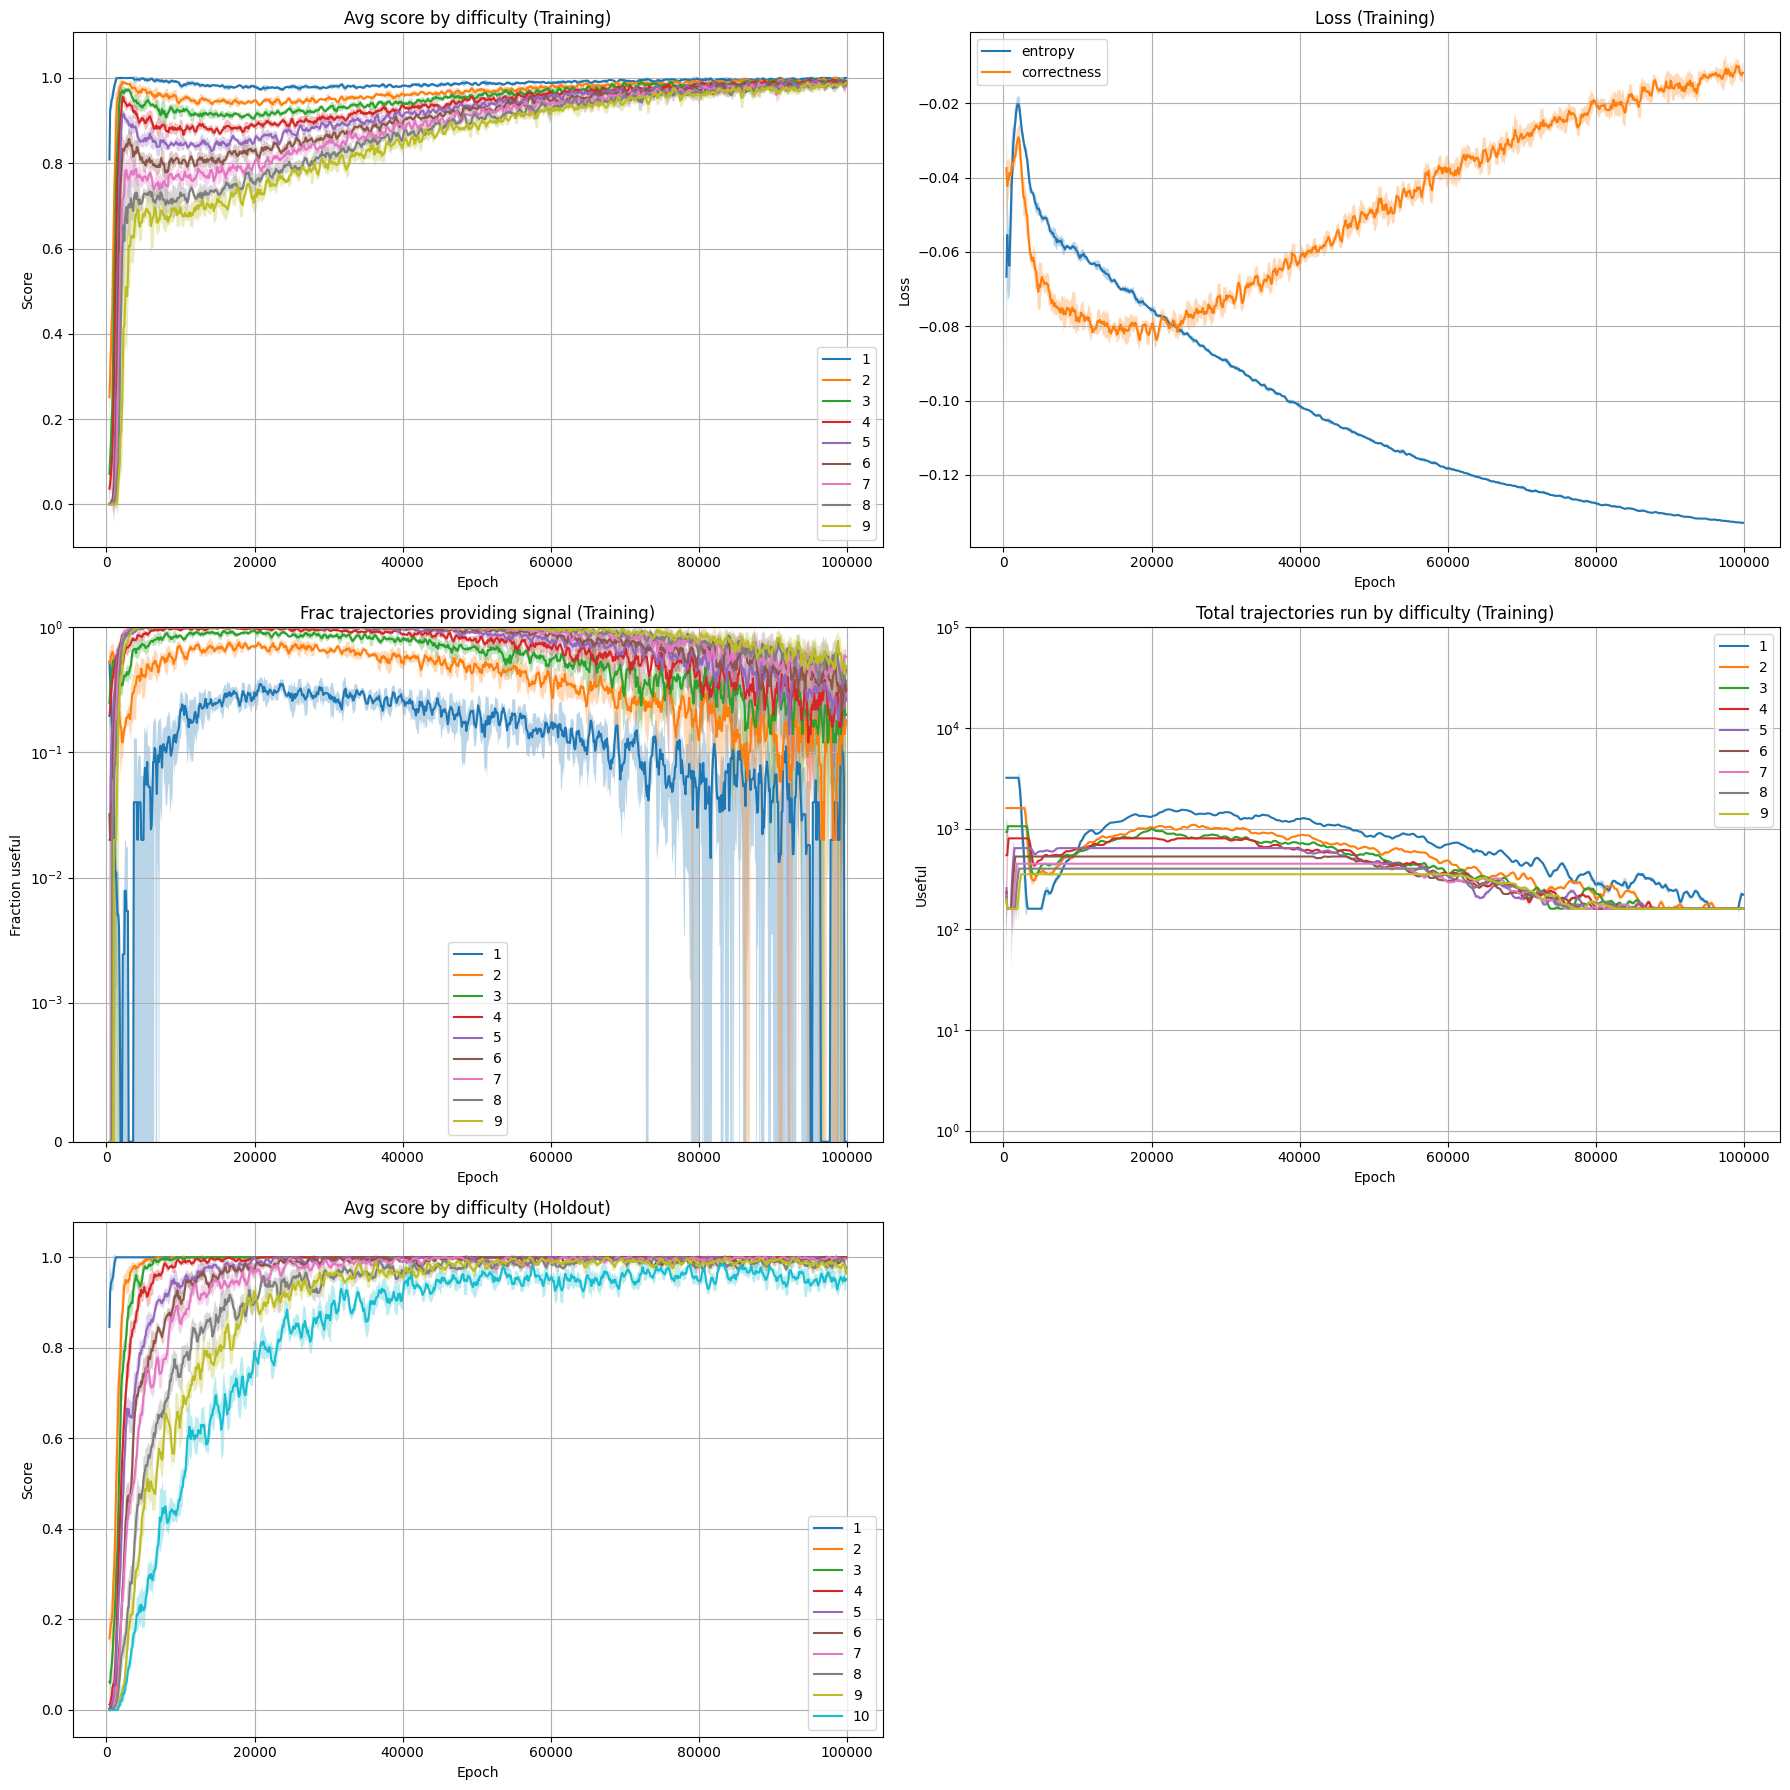

Config: w=5 h=5 layers=4x512 lr=0.0004 repeats=16 epochs=141421 t=1.0..0.1


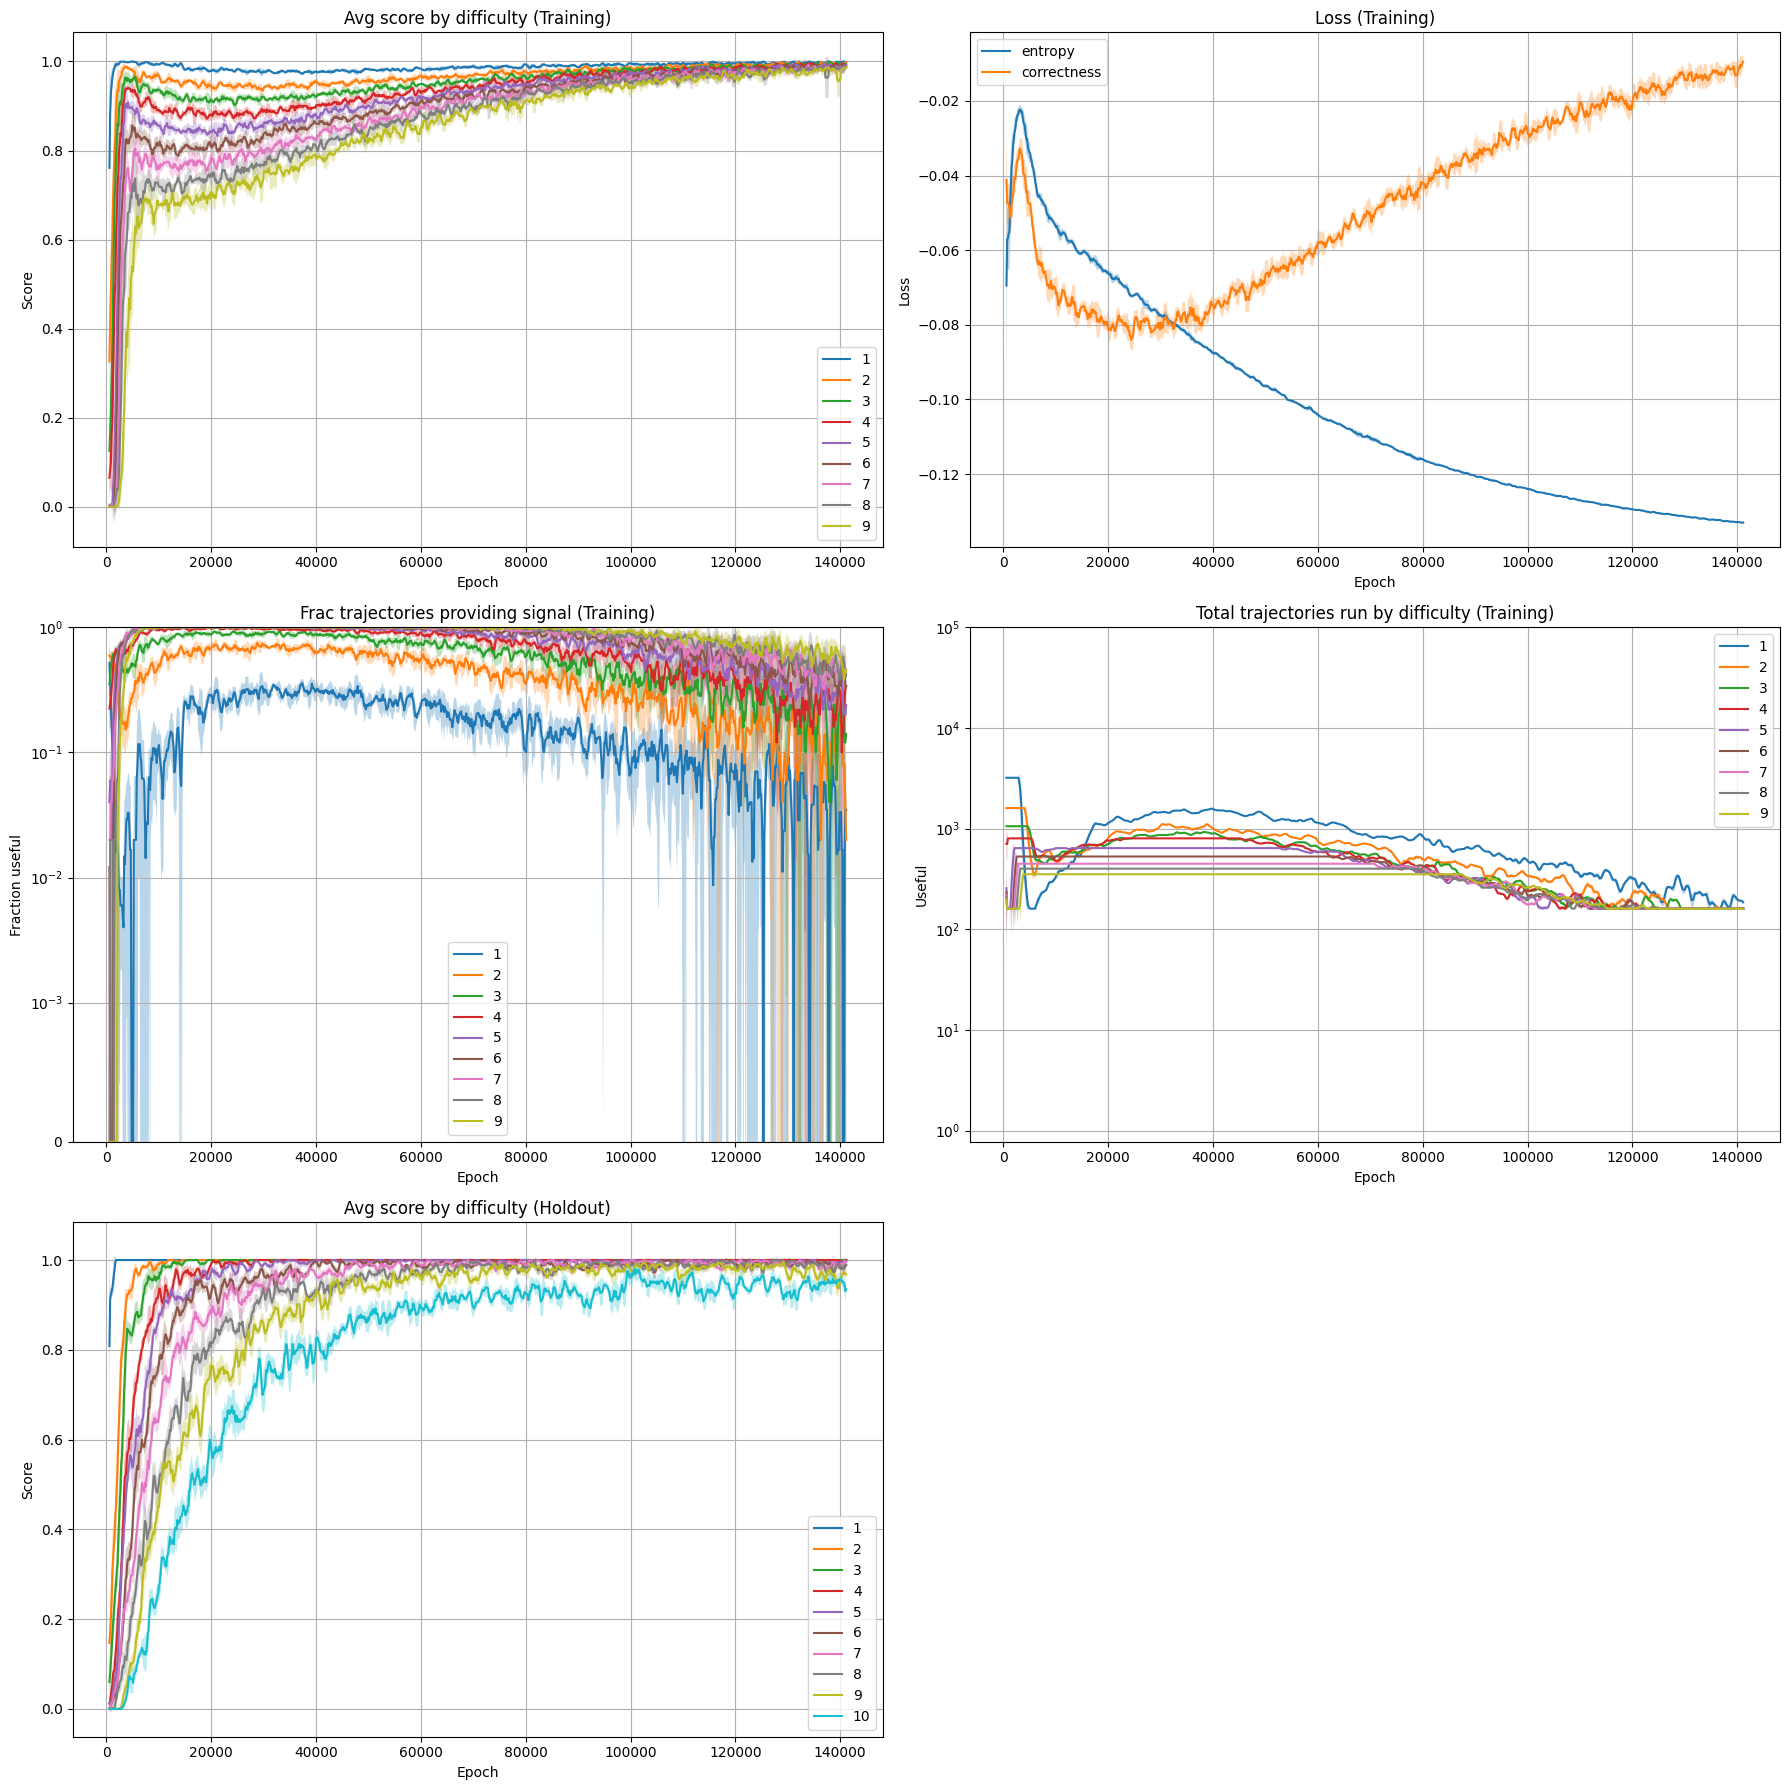

Config: w=5 h=5 layers=2x512 lr=0.0004 repeats=16 epochs=200000 t=1.0..0.1


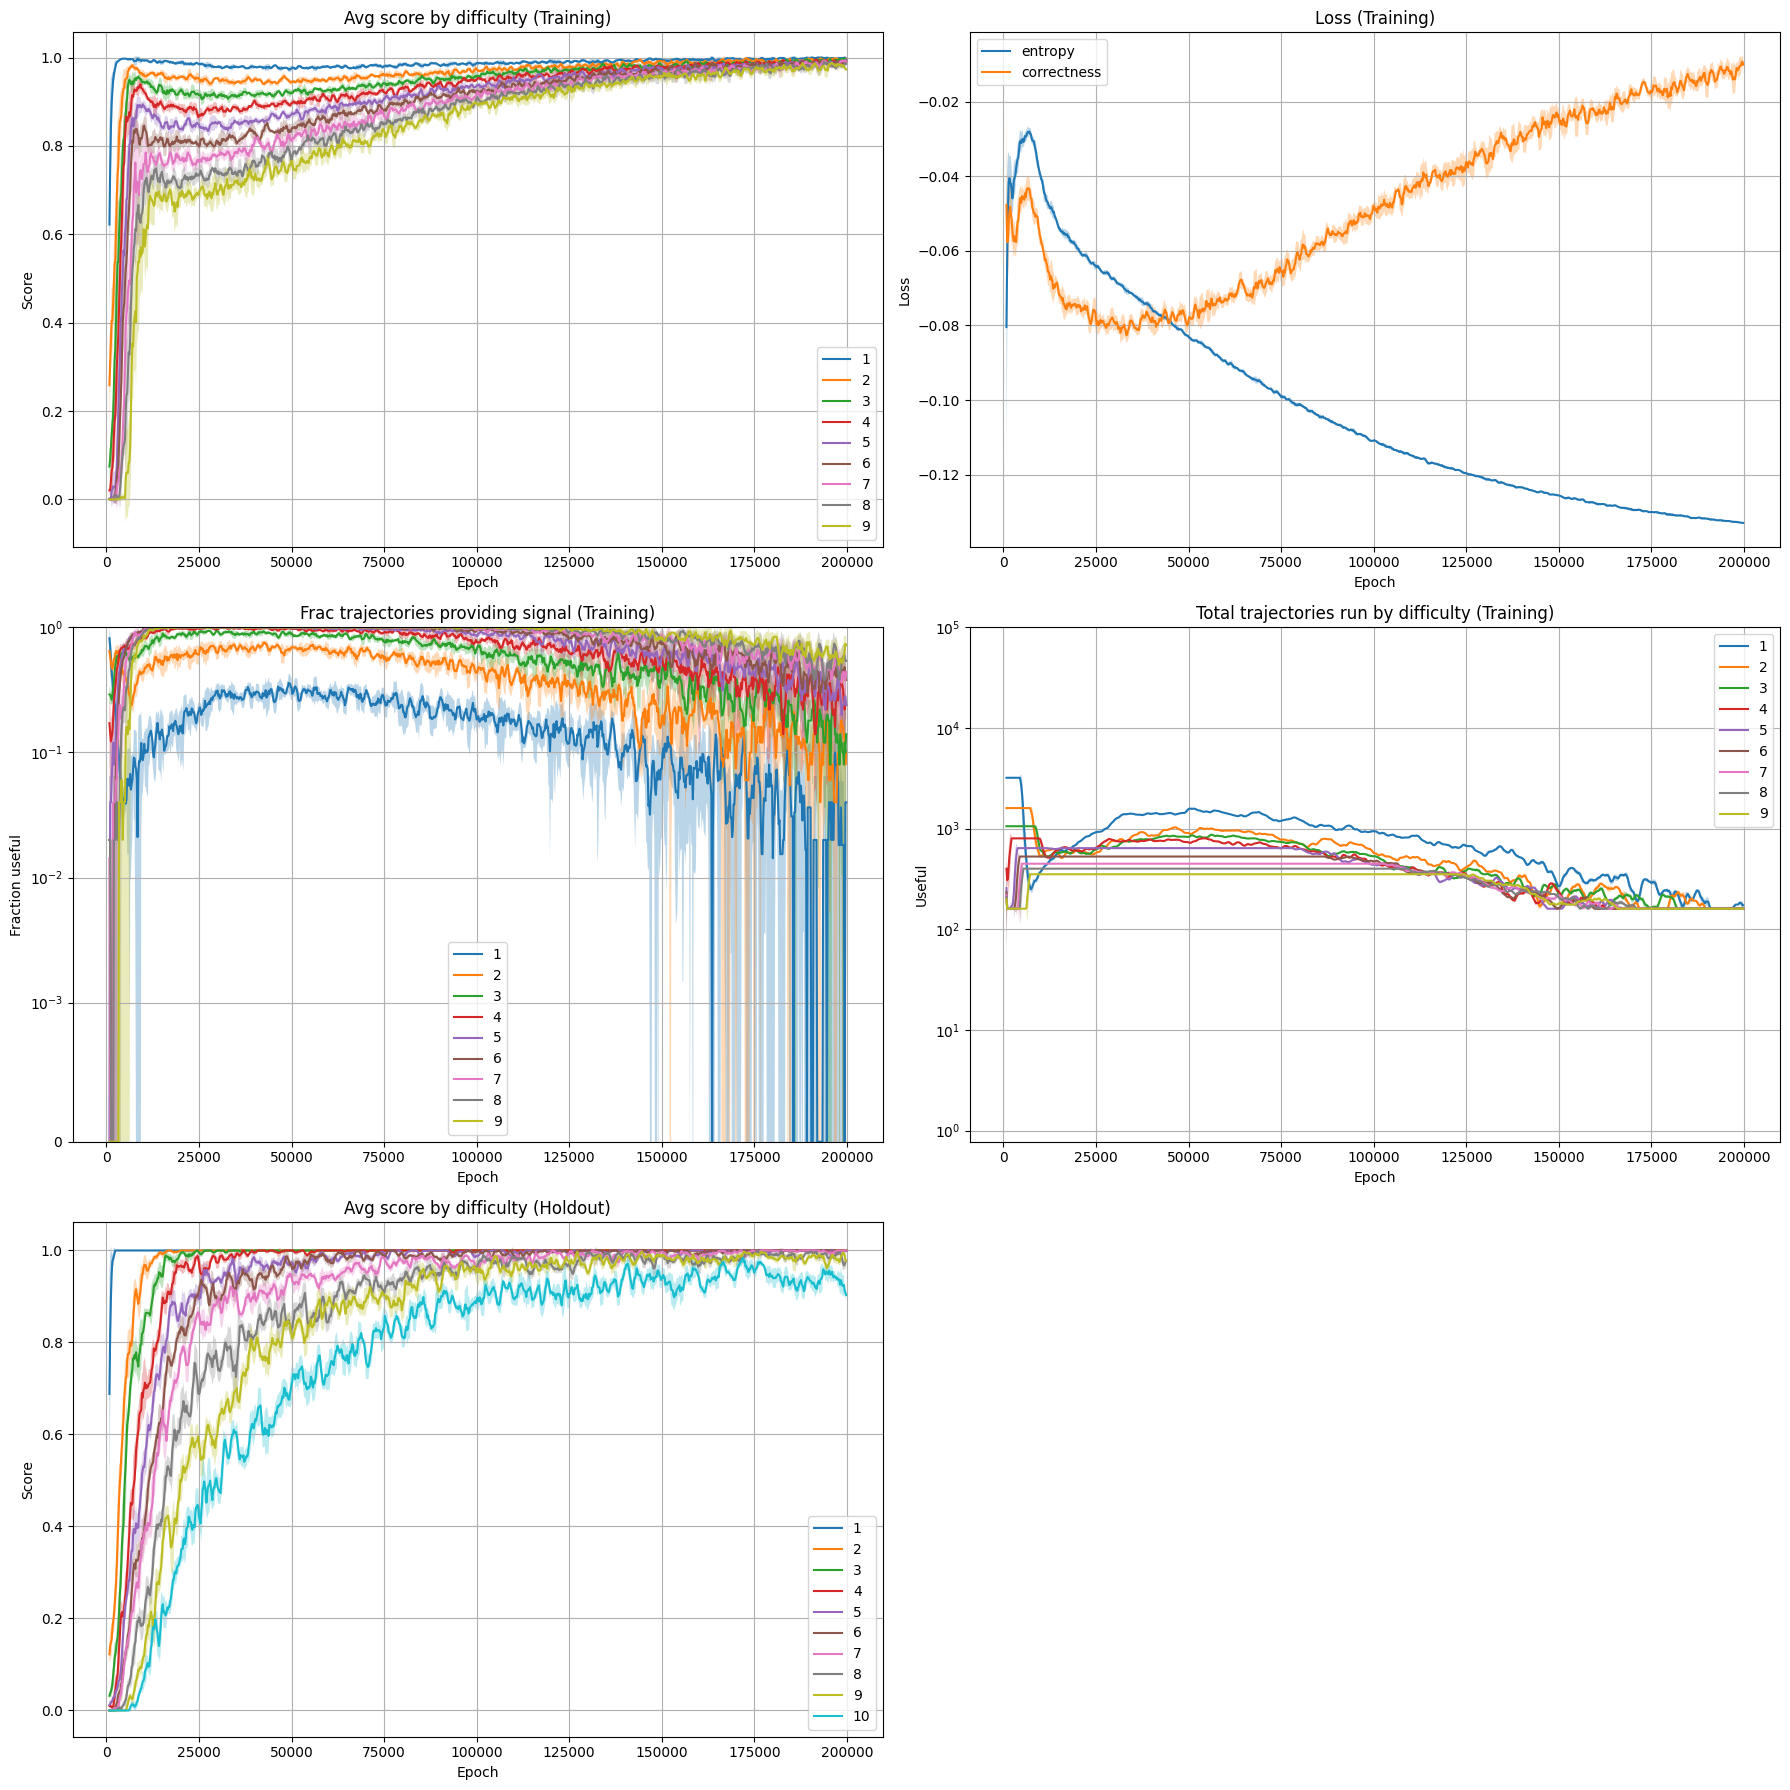

In [27]:
def score(progress: Progress) -> float:
    # How well did we do on the last few max-difficulty holdout examples?
    holdout_metrics: list[ProblemSetMetrics] = progress.update.holdout_metrics.metrics[
        10
    ][-50:]
    return float(np.mean([m.avg_score for m in holdout_metrics]))

results: list[Progress] = []
for result_file in sorted(globlib.glob("results/*.json")):
    loaded = Progress.from_json(open(result_file).read(), device)
    results.append(loaded)


results.sort(key=score, reverse=True)

for result in results:
    print(f"Loaded {result.config.format()}. Perf: {score(result)}")

best_results = results[:3]

for result in best_results:
    plot(result)

Pick out the best model from all the ones we trained.

In [28]:
best_result: Progress = results[0]
best_model: Model = best_result.update.model

Let's see what the model does on a few example mazes. First, some logic for determining the model's behavior in each cell of some examples:

In [29]:
# CellState is either 4 probabilities (up, down, left, right) or a string for walls/destination
type CellState = tuple[float, float, float, float] | str
type Posn = tuple[int, int]
type Solutions = dict[Posn, CellState]
solved_examples: list[Solutions] = []
examples: list[tuple[set[Posn], Posn]] = [
    (set(), (4, 4)),
    (set([(1, 1)]), (2, 2)),
    (set([(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]), (2, 2)),
    (set([(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)]), (4, 4)),
    (set([(0, 1), (1, 1), (2, 1), (3, 1), (1, 3), (2, 3), (3, 3), (4, 3)]), (4, 4)),
    (set([(4, 0), (3, 1), (1, 3), (0, 4)]), (4, 4)),
]
for wall_set, endpoint in examples:
    by_cell: Solutions = {}
    for y in range(5):
        for x in range(5):
            if (y, x) in wall_set:
                cell_value = "#"
            elif (y, x) == endpoint:
                cell_value = "X"
            else:
                maze = Maze(start=(y, x), end=endpoint, walls=wall_set, w=5, h=5)
                ps = GPUProblemSet.from_mazes(
                    mazes_by_difficulty={0: [maze]}, device=device
                )
                logits = best_model.get_logits(ps=ps)
                # Compute softmax at temperature=2/3 to get probabilities
                probs = torch.nn.functional.softmax(logits * 1.5, dim=1)
                [[p_up, p_down, p_left, p_right]] = probs.tolist()
                cell_value: tuple[float, float, float, float] = (
                    p_up,
                    p_down,
                    p_left,
                    p_right,
                )
            by_cell[(y, x)] = cell_value
    solved_examples.append(by_cell)

W0207 16:22:21.839000 2383 torch/_inductor/utils.py:1558] [16/0] Not enough SMs to use max_autotune_gemm mode


Then we can actually plot the model's behavior.

Black cell = wall. Green cell = target. Arrows = probability of model going in that direction with temperature 2/3.

We run with temperature 0.01 for eval, so effectively whichever arrow is the largest is the direction we move in eval.

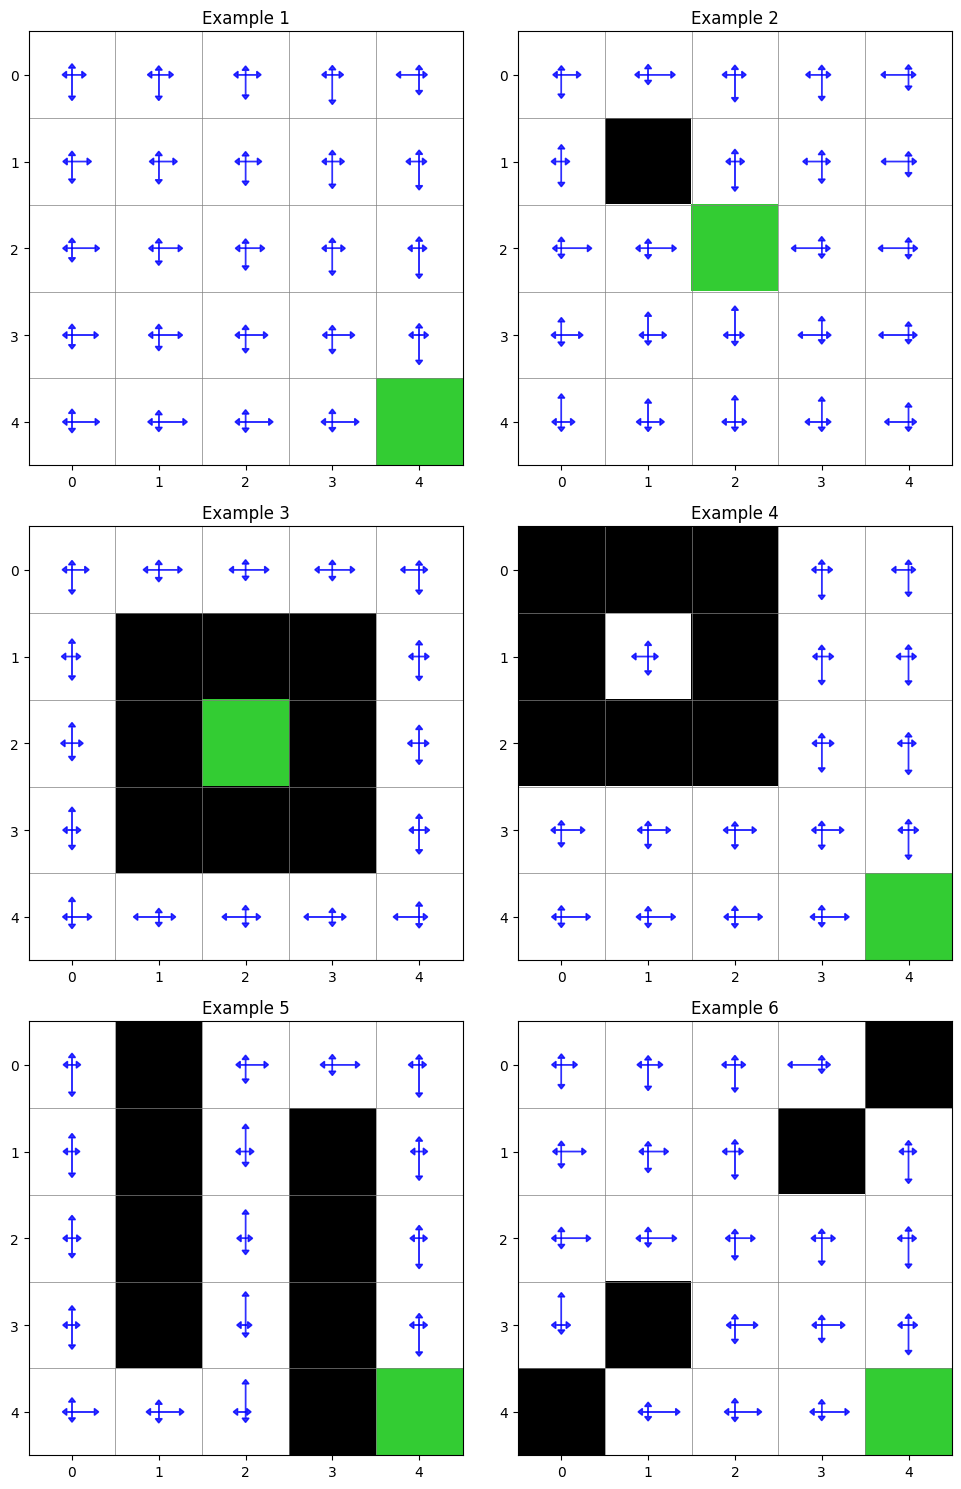

In [30]:
def plot_direction_grids(solved_examples: list[Solutions], grid_size: int = 5):
    """
    Visualize action probabilities from the neural network for each maze.
    Written by Claude; I didn't want to do this part. Thanks Claude

    - Walls: black
    - Destination: green
    - Other cells: 4 arrows (up, down, left, right) with length = probability
    """
    n_examples = len(solved_examples)
    n_cols = 2
    n_rows = (n_examples + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Flatten axes for easy indexing, handle edge cases
    if n_examples == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    axes = axes.flatten()

    # Direction vectors for up, down, left, right
    # In image coords: up = -y, down = +y, left = -x, right = +x
    dir_vectors = {
        "up": (0, -1),
        "down": (0, 1),
        "left": (-1, 0),
        "right": (1, 0),
    }

    for idx, solution in enumerate(solved_examples):
        ax = axes[idx]

        # Create background grid (white by default)
        background = np.ones((grid_size, grid_size, 3))

        # Collect arrow data for each direction
        arrows = []  # list of (x, y, dx, dy, prob)

        for (y, x), cell in solution.items():
            if cell == "#":
                # Wall: black
                background[y, x] = [0, 0, 0]
            elif cell == "X":
                # Destination: green
                background[y, x] = [0.2, 0.8, 0.2]
            else:
                # Probabilities tuple (up, down, left, right)
                p_up, p_down, p_left, p_right = cell
                probs = {"up": p_up, "down": p_down, "left": p_left, "right": p_right}

                for direction, prob in probs.items():
                    dx, dy = dir_vectors[direction]
                    arrows.append((x, y, dx, dy, prob))

        # Draw background
        ax.imshow(
            background,
            origin="upper",
            extent=(-0.5, grid_size - 0.5, grid_size - 0.5, -0.5),
        )

        # Draw arrows
        if arrows:
            max_arrow_len = 0.7

            for x, y, dx, dy, prob in arrows:
                # Arrow length proportional to probability
                arrow_len = prob * max_arrow_len
                ax.arrow(
                    x,
                    y,
                    dx * arrow_len,
                    dy * arrow_len,
                    head_width=0.08,
                    head_length=0.05,
                    fc="blue",
                    ec="blue",
                    alpha=0.8,
                    length_includes_head=True,
                )

        # Draw grid lines
        for i in range(grid_size + 1):
            ax.axhline(i - 0.5, color="gray", linewidth=0.5)
            ax.axvline(i - 0.5, color="gray", linewidth=0.5)

        ax.set_xlim(-0.5, grid_size - 0.5)
        ax.set_ylim(grid_size - 0.5, -0.5)  # Flip y so (0,0) is top-left
        ax.set_aspect("equal")
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))
        ax.set_title(f"Example {idx + 1}")

    # Hide any unused axes
    for idx in range(n_examples, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


plot_direction_grids(solved_examples)

That's it!

Training this way was way slower than training with normal differential optimization, because the signal is super sparse and super noisy. But it does work!

An important detail: look at how the model generalized in example 5. We only train it with problems up to 9 steps, but it works all the way up to 13 steps before getting stuck, and even then it seems to be using a mostly-reasonable heuristic where with a low enough temperature it would eventually solve the maze.